In [85]:
import ANFIS.operators as op
import ANFIS.params as anfis_params
from ANFIS.ANFIS import ANFIS

import pprint
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

<H1>Methods for operators plotting</H1>

In [86]:
def plotNorm(fun, ax):
    X = np.arange(0, 1.01, 0.01)
    Y = np.arange(0, 1.01, 0.01)
    Z = np.array([np.array([fun(x,y) for x in X]) for y in Y] )
    X, Y = np.meshgrid(X, Y)

    surf = ax.plot_surface(X, Y, Z, cmap=cm.jet, antialiased=True)

    ax.set_zlim(-0.1, 1.1)
    ax.zaxis.set_major_locator(LinearLocator(11))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.view_init(elev=20, azim=250)

def plotNorms(fun1, fun2):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122,projection='3d')

    plotNorm(fun1, ax1)
    plotNorm(fun2, ax2)

    plt.show()

<H1>Zadeh norms</H1>

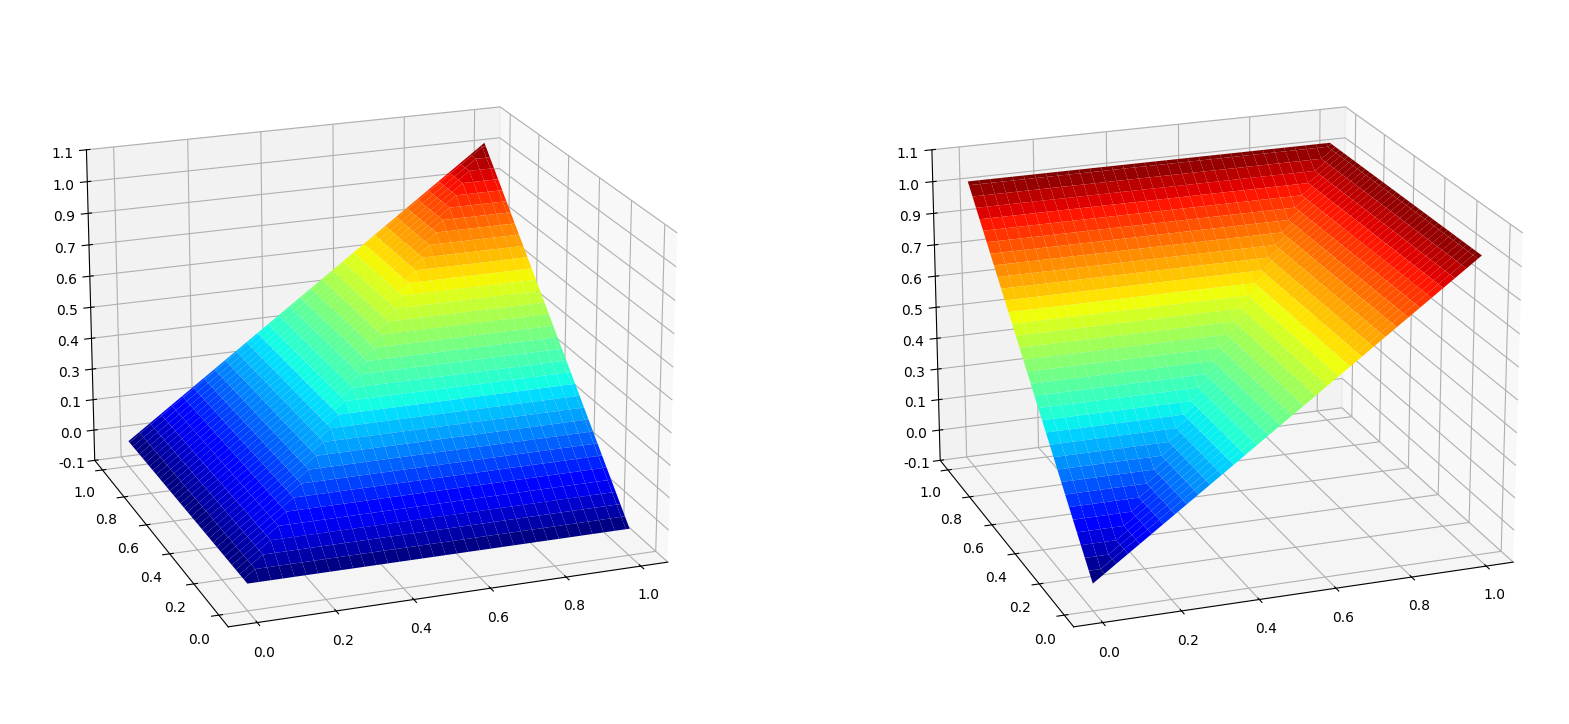

In [87]:
def zadeh_t(x,y):
    return min(x,y)
def zadeh_s(x,y):
    return max(x,y)
plotNorms(zadeh_t,zadeh_s)

<H1>Algebraic/Probabilistic norms</H1>

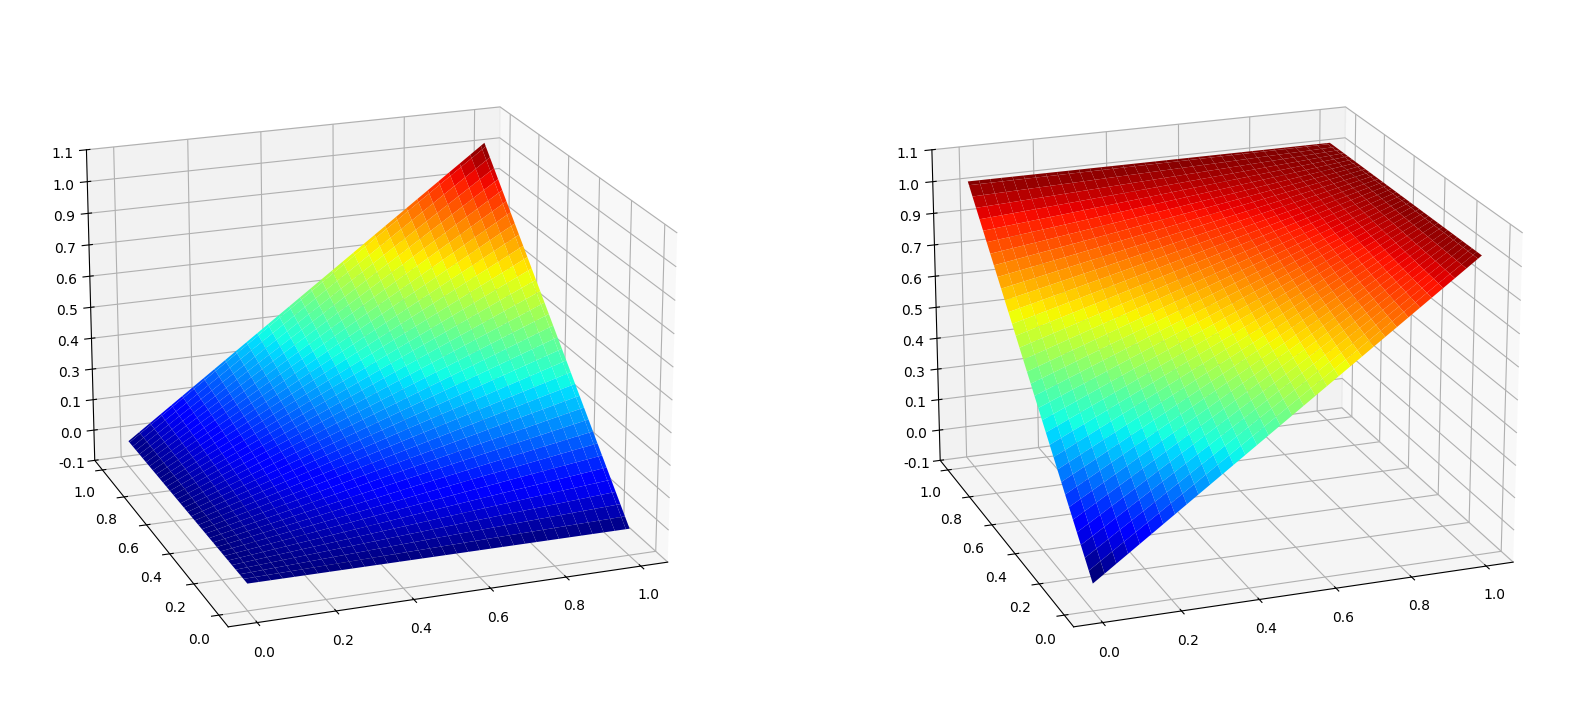

In [88]:
def algebraic_t(x,y):
    return x*y
def probabilistic_s(x,y):
    return x+y-x*y
plotNorms(algebraic_t,probabilistic_s)

<H1>Łukasiewicz norms</H1>

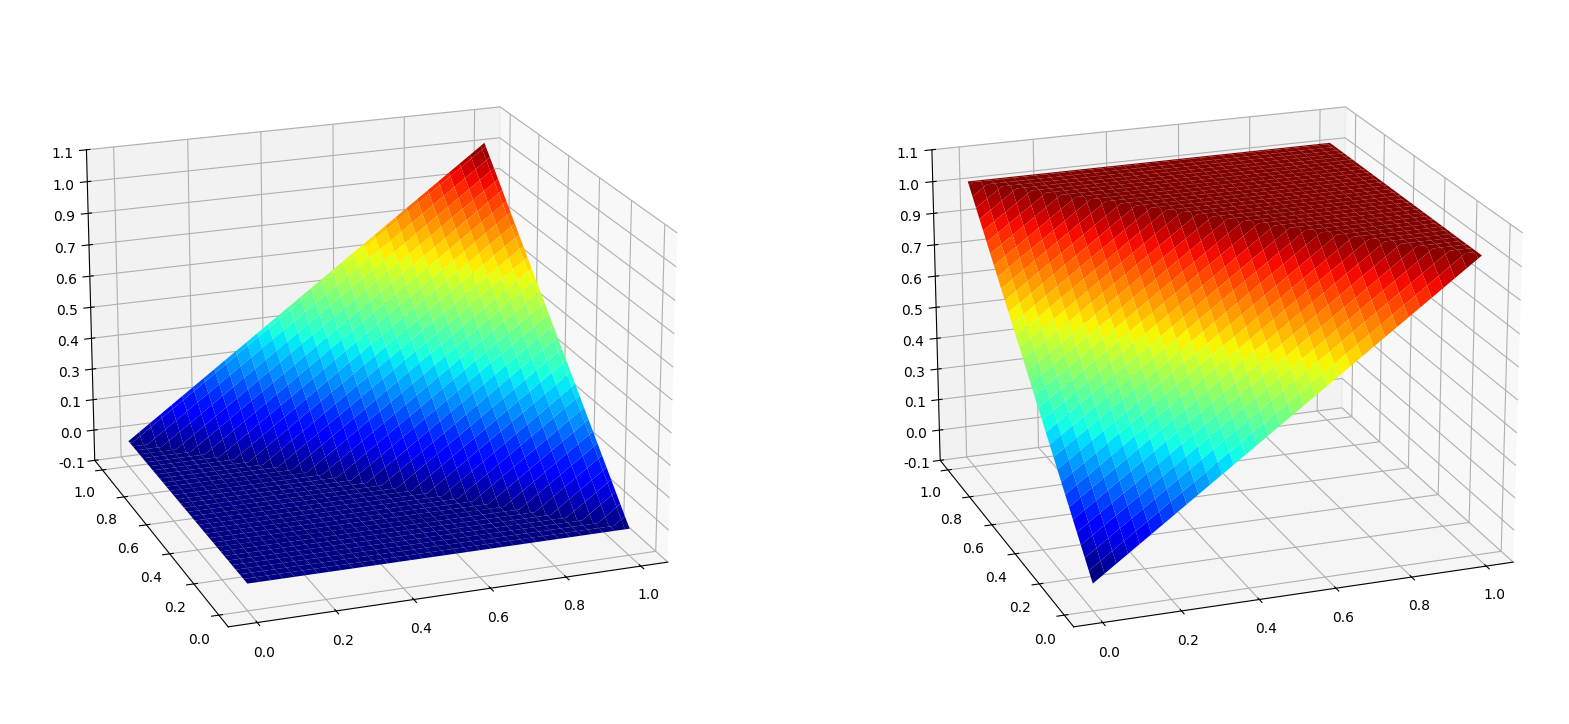

In [89]:
def lukasiewicz_t(x,y):
    return max(x+y-1.0,0)
def lukasiewicz_s(x,y):
    return min(x+y,1)
plotNorms(lukasiewicz_t,lukasiewicz_s)

<H1>Fodor norms</H1>

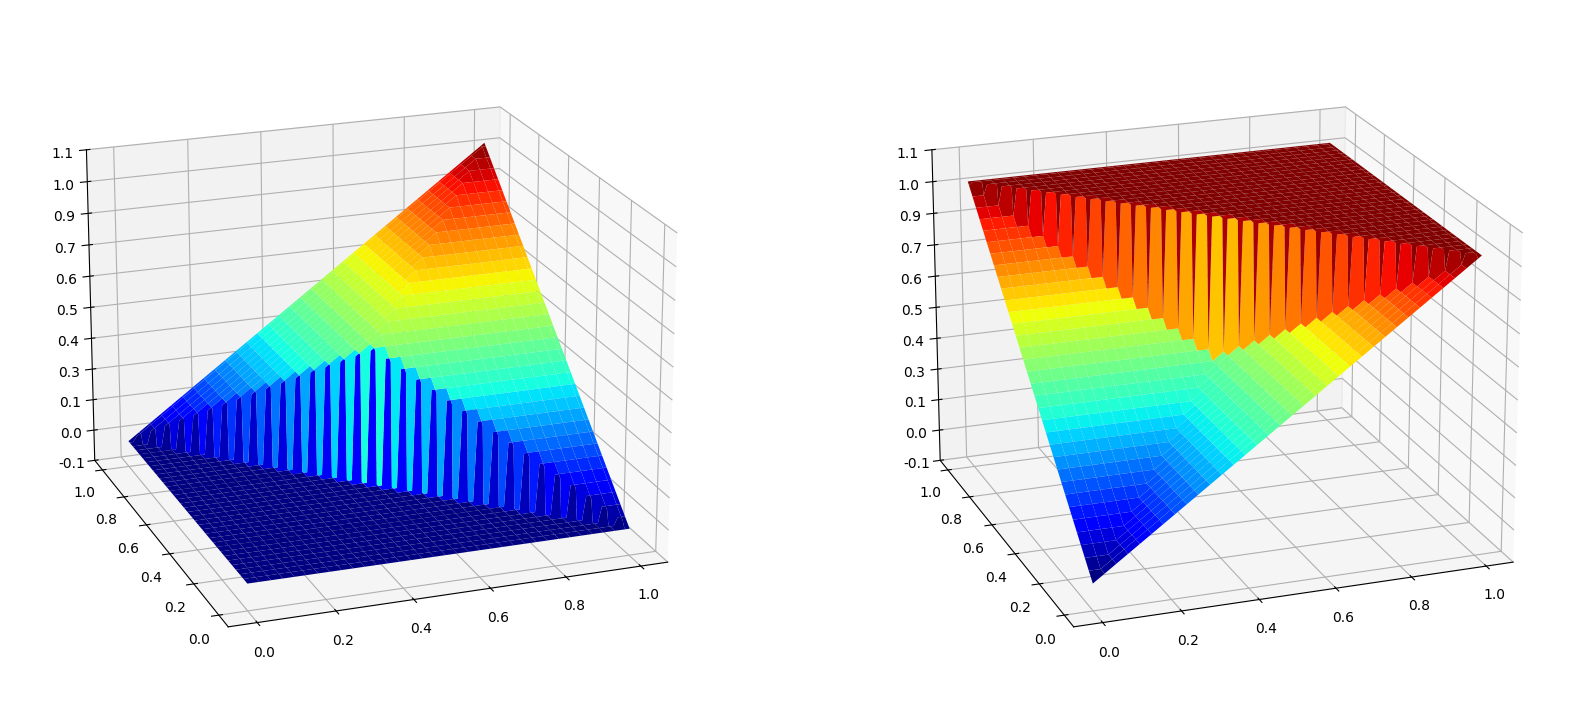

In [90]:
def fodor_t(x,y):
    if x+y>1:
        return min(x,y)
    else:
        return 0
def fodor_s(x,y):
    if x+y<1:
        return max(x,y)
    else:
        return 1
plotNorms(fodor_t,fodor_s)

<H1>Drastic norms</H1>

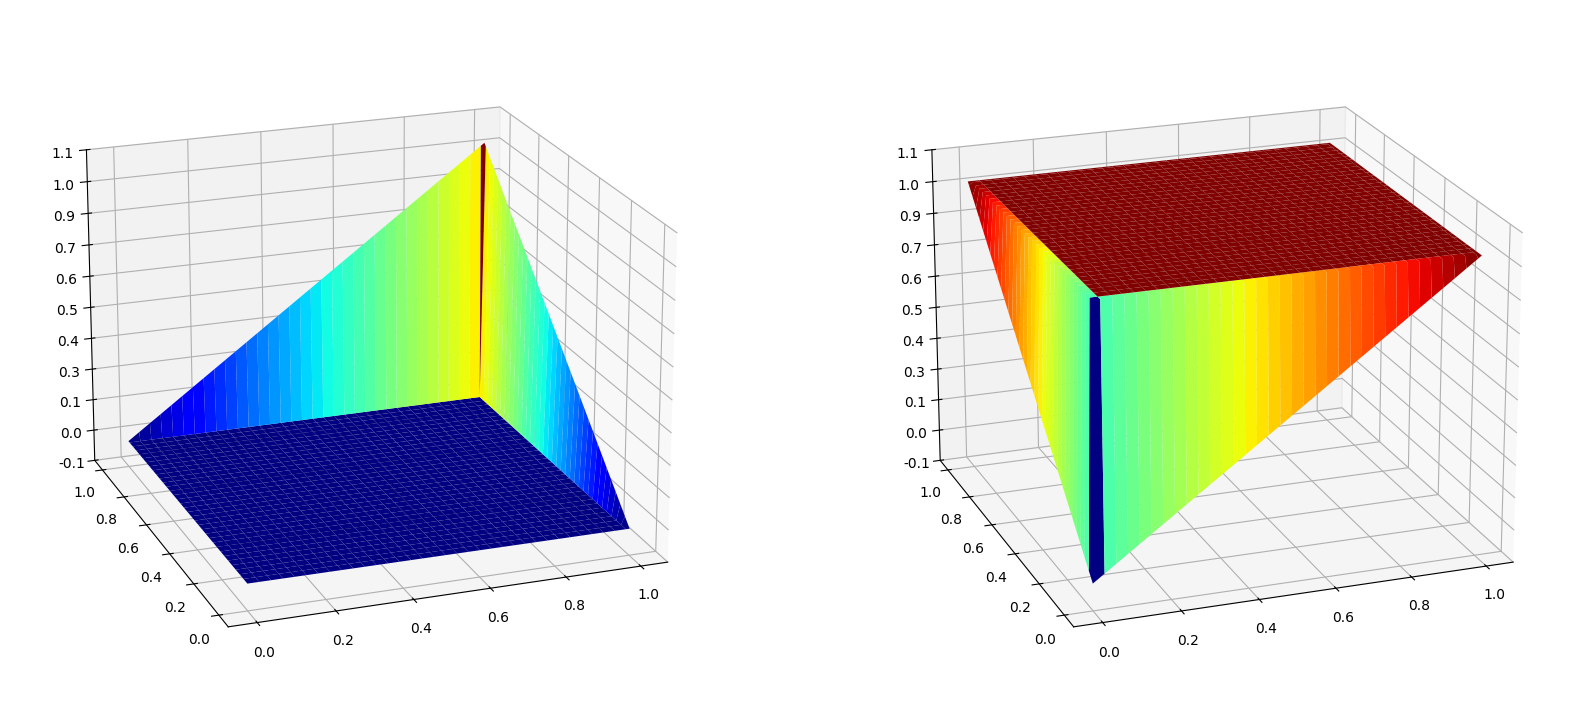

In [91]:
def drastic_t(x,y):
    if max(x,y) == 1:
        return min(x,y)
    else:
        return 0
def drastic_s(x,y):
    if min(x,y) == 0:
        return max(x,y)
    else:
        return 1
plotNorms(drastic_t,drastic_s)

<H1>Einstein norms</H1>

\begin{equation*}
E(x,y)=\frac{xy}{2-(x+y-xy)}     \quad\quad\quad\quad     E'(x,y)=\frac{x+y}{1+xy}
\end{equation*}

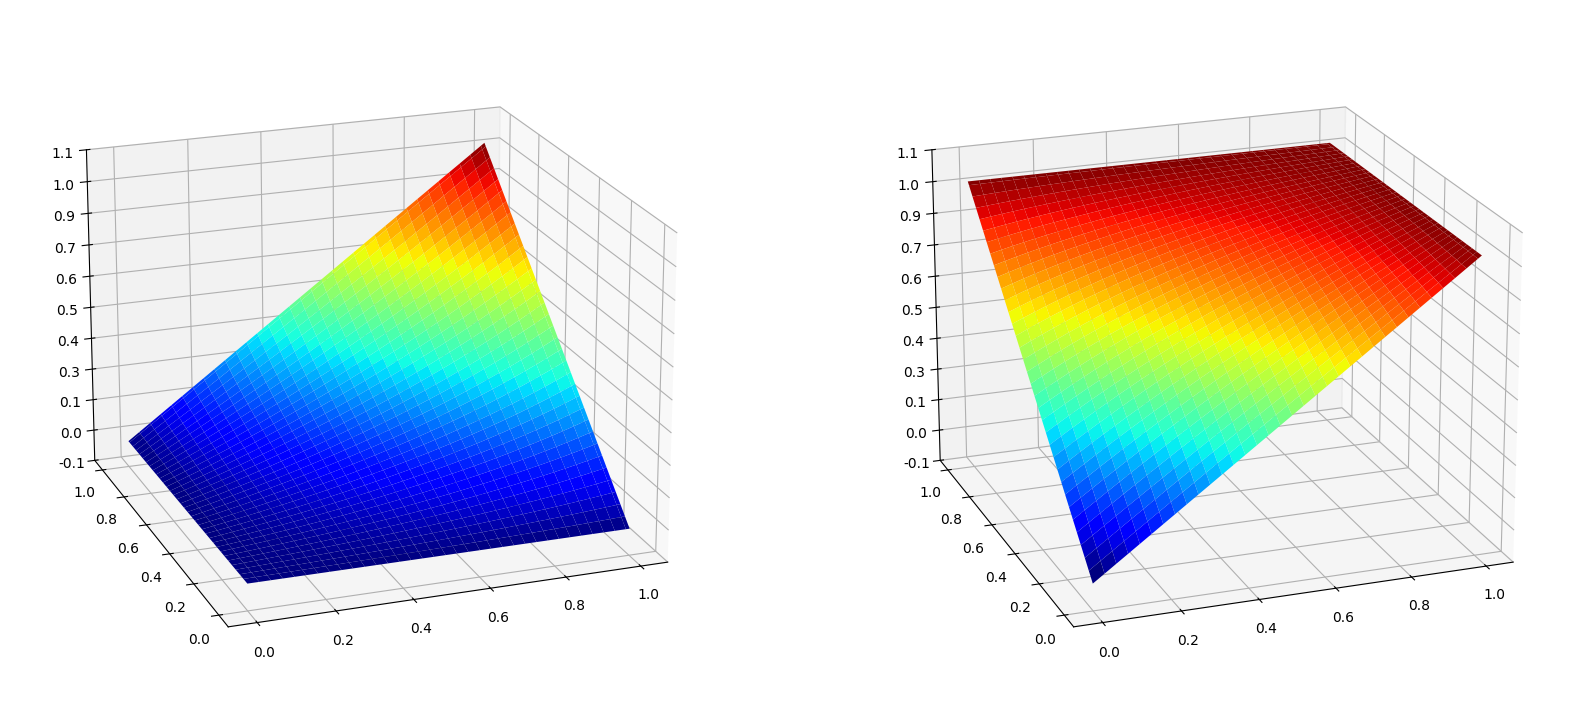

In [92]:
def einstein_t(x,y):
    return x * y / (2 - (x + y - x * y))
def einstein_s(x,y):
    return (x + y) / (1 + x * y)
plotNorms(einstein_t,einstein_s)

<H1>Task</H1>
Examine each of t-norms and s-norms in the notebook.

- Implement your own t-norm and s-norm.

- For each operator, train ANFIS model to multiply numbers.

- Compare the results and time of training.

First let's implement custom t and s norm and watch how they behave

In [93]:
def custom_t():
    pass
def custom_s():
    pass

Now let's create training method and data preparation method

In [98]:
def prepare_data(size: int):
    x = np.arange(0, size, 1)
    x,y = np.meshgrid(x, x)
    dataX = x.flatten() # x values of the grid
    dataY = y.flatten() # y values of the grid
    dataXY = np.column_stack((dataX,dataY)) # 2d data for ANFIS input
    data_labels = dataX * dataY
    X_train, X_test, y_train, y_test = train_test_split(dataXY, data_labels, test_size=0.2, random_state=25)
    return X_train, X_test, y_train, y_test


def training_method(X_train, X_test, y_train, y_test, operator, results = None):
    print(f"\n=================================================================================\nTraining with operator {operator.__name__}")
    # First create fuzzy input variables
    varX = anfis_params.FuzzyInputVariable_2Trapezoids(0.5, 0.5, "X axis", ["L", "H"])
    varY = anfis_params.FuzzyInputVariable_2Trapezoids(0.5, 0.5, "Y axis", ["L", "H"])

    # Init ANFIS
    fis = ANFIS([varX, varY], X_train.T, y_train, operator)
    print(f"Initial params for {operator.__name__} operator:\nPremises: ", fis.premises, "\nConclusions: ", fis.tsk)
    fis.show_results()

    # Train
    start = time.time()
    fis.train(True, True, False, True, n_iter=50)
    end = time.time()

    print(f'Training results:\nTime elapsed: {end - start}\nMembership functions after learning:')
    plt.figure()
    varX.show()
    plt.legend()
    plt.figure()
    varY.show()
    plt.legend()
    plt.show()

    print("Training data results:")
    fis.training_data = X_train.T
    fis.expected_labels = y_train
    fis.show_results()

    print("Evaluation data results:")
    fis.training_data = X_test.T
    fis.expected_labels = y_test
    fis.show_results()

    y_pred = fis.anfis_estimate_labels(fis.premises,fis.op,fis.tsk)
    y_pred = list(map(round,y_pred.flatten()))
    print("y_test:\n", y_test)
    print("y_pred:\n", y_pred)
    print(confusion_matrix(y_test, y_pred))

    if results is not None:
        results.append(
            {
                "operator": operator.__name__,
                "time_elapsed": end - start,
                "test_accuracy": float(np.sum(y_test == y_pred) / np.size(y_test)),
                "confusion_matrix": confusion_matrix(y_test, y_pred)
            }
        )
    print("\n=================================================================================\n")

And now we can finally use our methods to prepare data and train anfis. But first let's init list of operators and results_dict


Training with operator zadehT
Initial params for zadehT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.47847822 0.09888763 0.44370868]
 [0.6045692  0.56443304 0.48076034]
 [0.07836943 0.97009558 0.74284123]
 [0.95254395 0.37125626 0.08226247]]


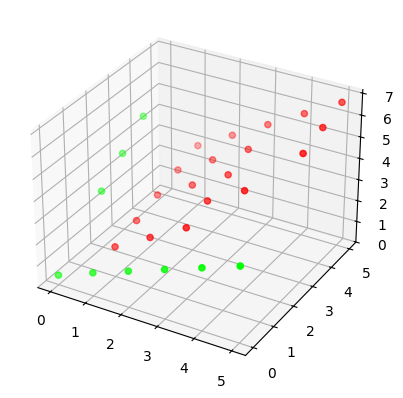

Optymalization finished!
With errors:   7.144054423105678
No ev:  34589
No it:  50
Training results:
Time elapsed: 12.018983602523804
Membership functions after learning:


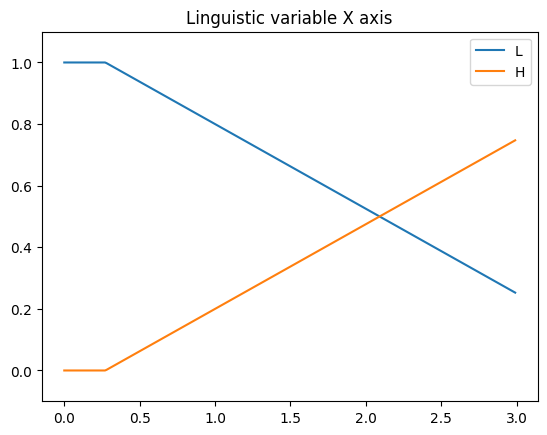

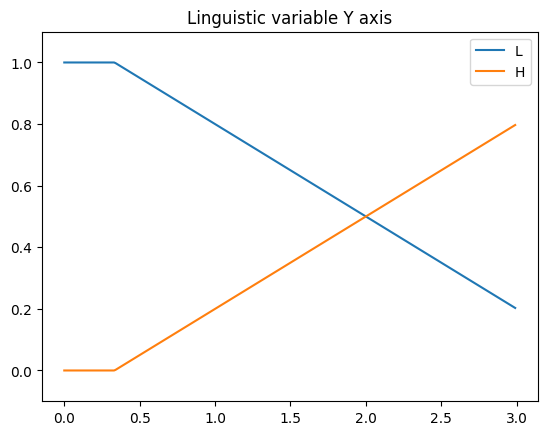

Training data results:


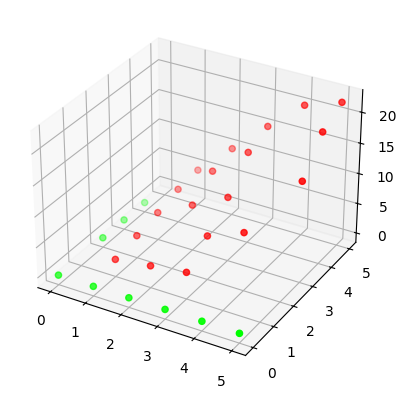

Evaluation data results:


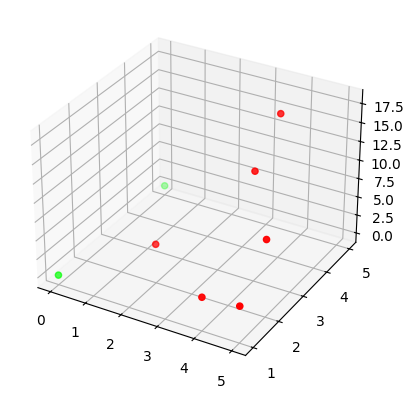

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [0, 18, 0, 3, 9, 13, 4, 4]
[[2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]]



Training with operator zadehS
Initial params for zadehS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.9414176  0.05954275 0.6827638 ]
 [0.22478726 0.07520122 0.25473635]
 [0.77541205 0.82172428 0.52082701]
 [0.37987093 0.5950504  0.06457608]]


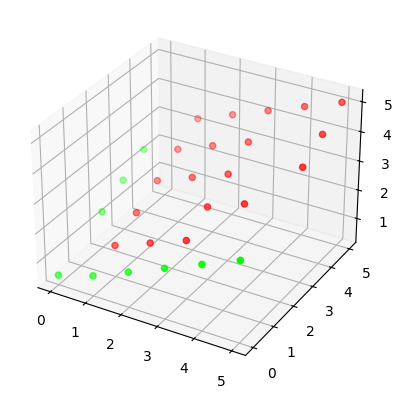

Optymalization finished!
With errors:   57.55641637440438
No ev:  28018
No it:  50
Training results:
Time elapsed: 11.235738039016724
Membership functions after learning:


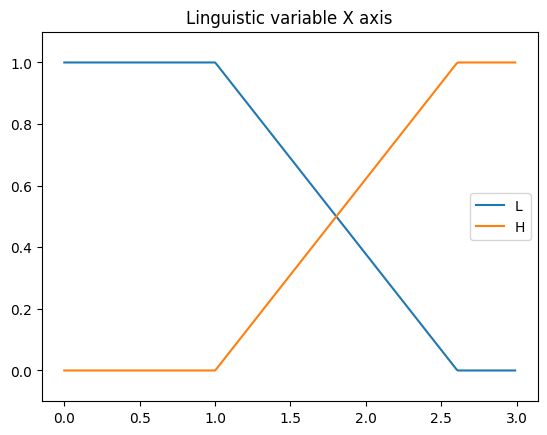

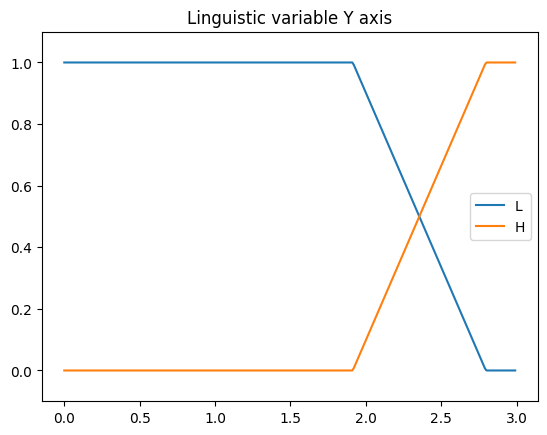

Training data results:


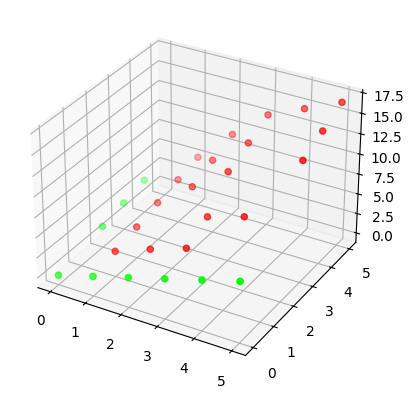

Evaluation data results:


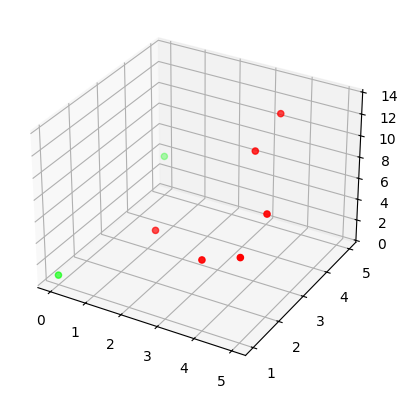

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [4, 13, 1, 6, 9, 12, 5, 8]
[[0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]



Training with operator algebraicT
Initial params for algebraicT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.37228328 0.6878066  0.07839384]
 [0.82043836 0.595079   0.70082266]
 [0.08880817 0.81990293 0.52074969]
 [0.05823358 0.46615618 0.63116082]]


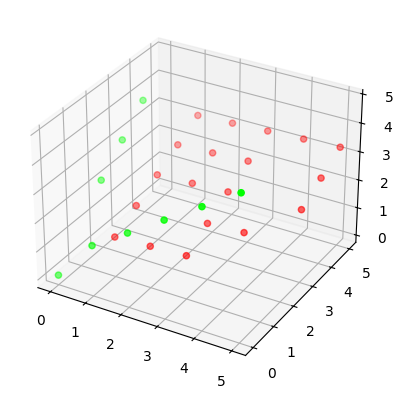

Optymalization finished!
With errors:   7.900056453727917
No ev:  27914
No it:  50
Training results:
Time elapsed: 11.665167093276978
Membership functions after learning:


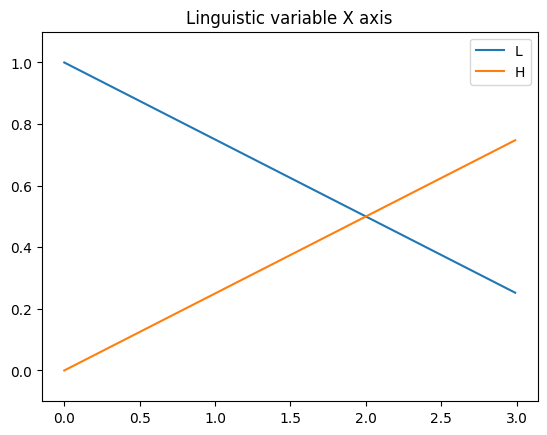

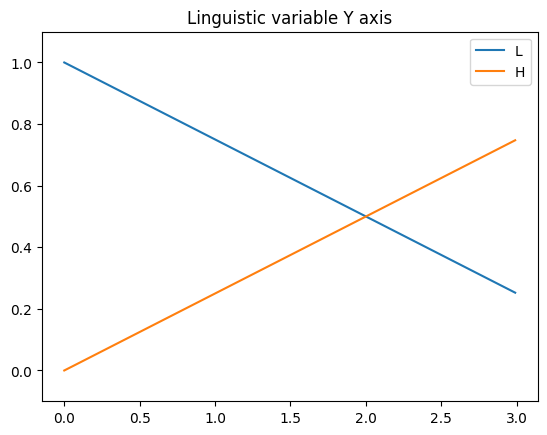

Training data results:


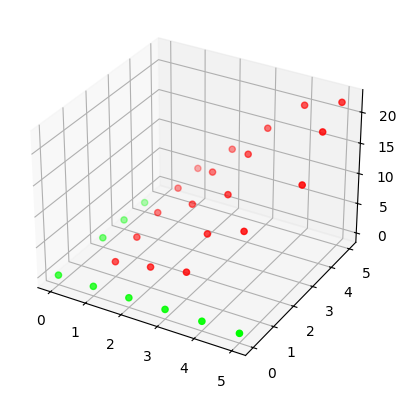

Evaluation data results:


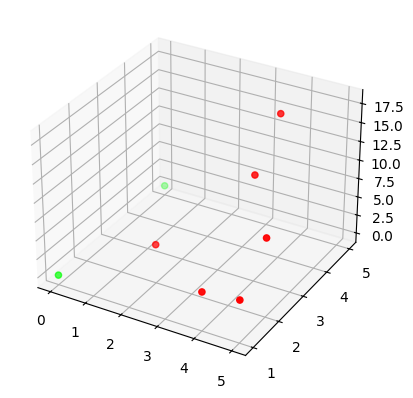

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [0, 18, 0, 4, 9, 13, 4, 4]
[[2 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]]



Training with operator probabilisticS
Initial params for probabilisticS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.55053542 0.52499812 0.61498247]
 [0.9773716  0.37472926 0.20467702]
 [0.16081405 0.90774381 0.27969975]
 [0.5457927  0.37570874 0.31698556]]


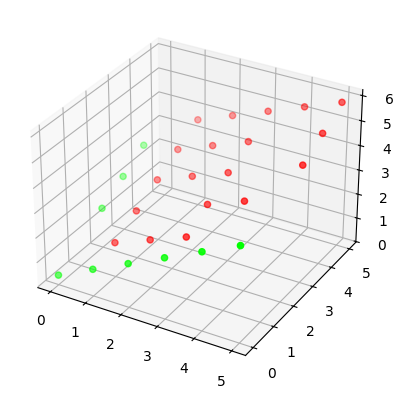

Optymalization finished!
With errors:   57.55435679461964
No ev:  24928
No it:  50
Training results:
Time elapsed: 12.232364654541016
Membership functions after learning:


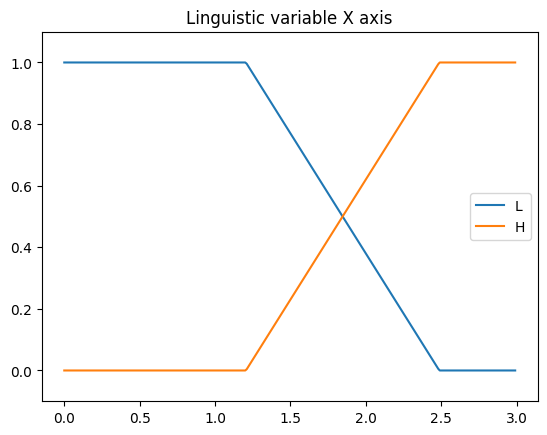

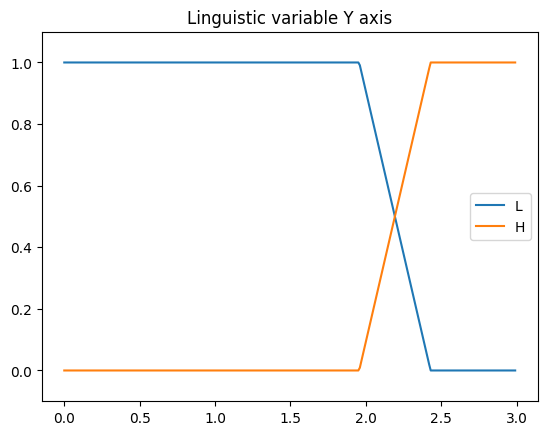

Training data results:


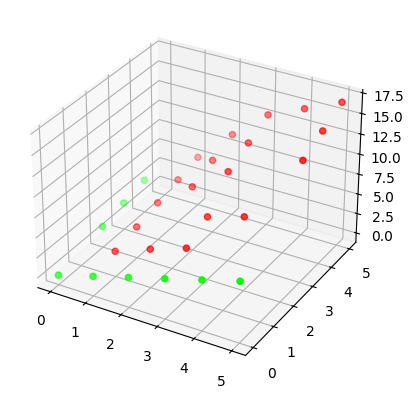

Evaluation data results:


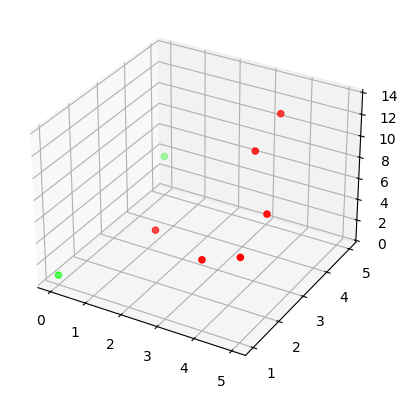

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [4, 13, 1, 6, 9, 12, 5, 8]
[[0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]



Training with operator lukasiewiczT
Initial params for lukasiewiczT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.30136188 0.15557674 0.44428819]
 [0.79172017 0.44127124 0.1600126 ]
 [0.70432101 0.20312234 0.32993864]
 [0.63705822 0.52385384 0.63222267]]


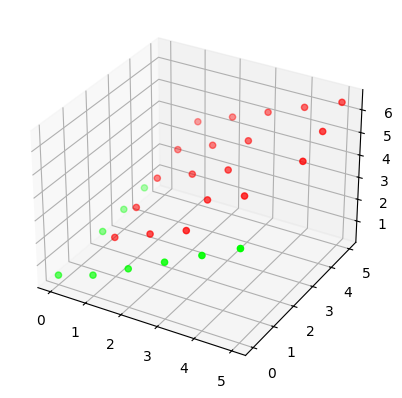

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   16.222786195324016
No ev:  35382
No it:  50
Training results:
Time elapsed: 12.110535383224487
Membership functions after learning:


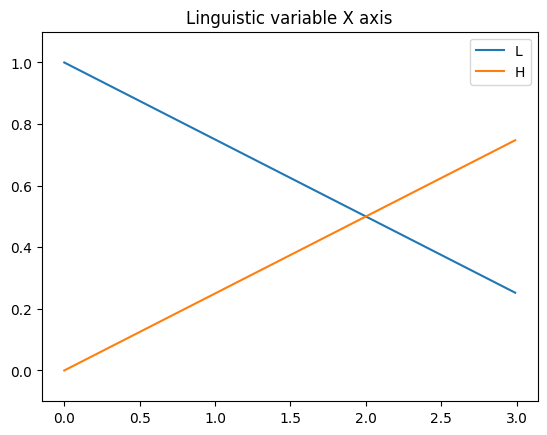

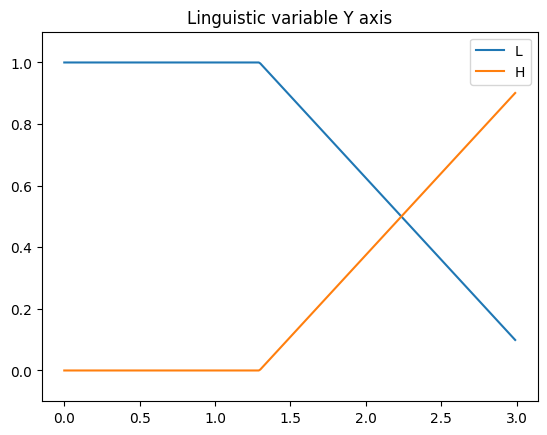

Training data results:


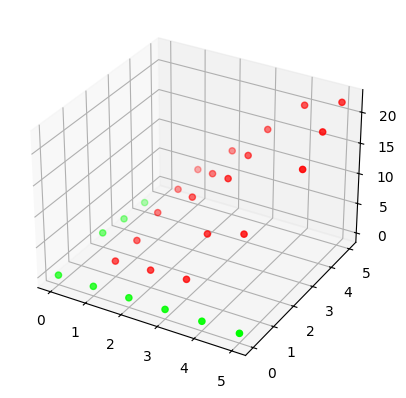

Evaluation data results:


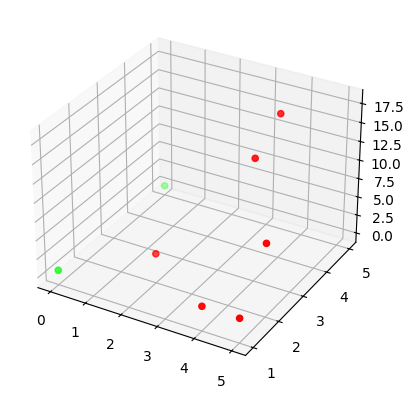

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [0, 18, 1, 2, 9, 15, 3, 2]
[[1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]]



Training with operator lukasiewiczS
Initial params for lukasiewiczS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.73657199 0.60173659 0.49582582]
 [0.57044167 0.34534576 0.50087984]
 [0.35641291 0.19994932 0.62713253]
 [0.65044883 0.43978223 0.57985723]]


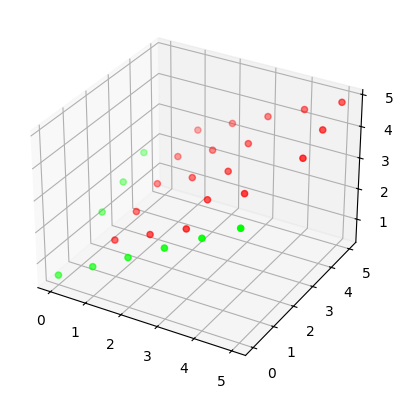

Optymalization finished!
With errors:   57.53808141884132
No ev:  26237
No it:  50
Training results:
Time elapsed: 8.514255046844482
Membership functions after learning:


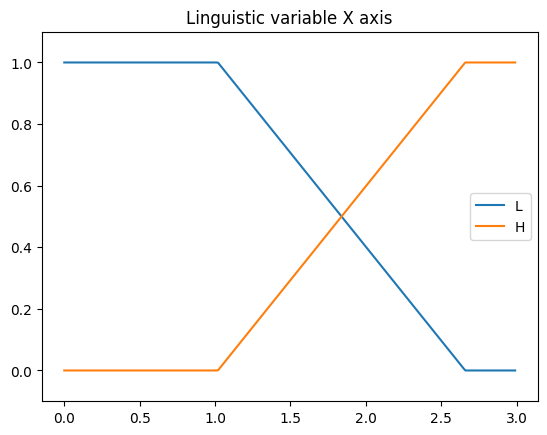

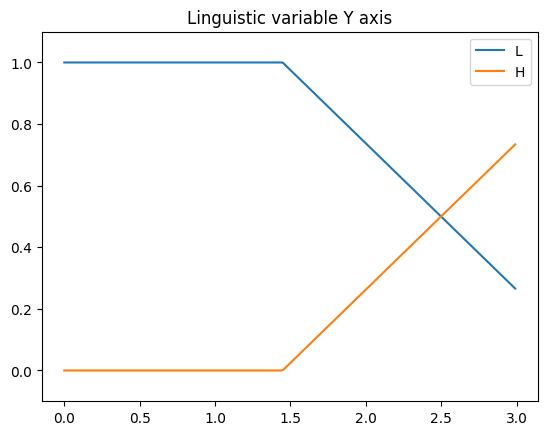

Training data results:


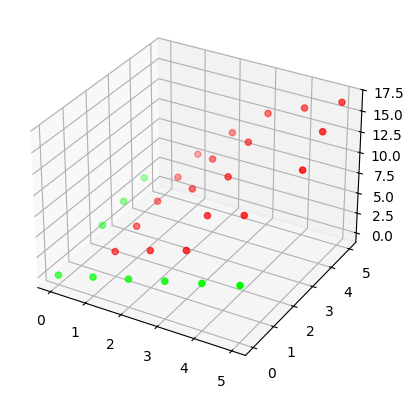

Evaluation data results:


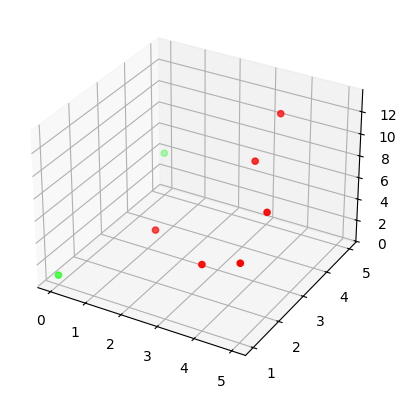

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [4, 13, 1, 6, 9, 11, 5, 7]
[[0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator einsteinT
Initial params for einsteinT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.26617513 0.61291465 0.67243978]
 [0.30025651 0.01102104 0.70116653]
 [0.08213972 0.54568912 0.62612141]
 [0.29335352 0.15625481 0.33259869]]


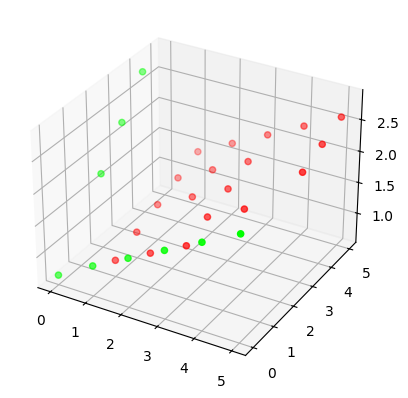

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   37.001061706401856
No ev:  22114
No it:  50
Training results:
Time elapsed: 7.269062519073486
Membership functions after learning:


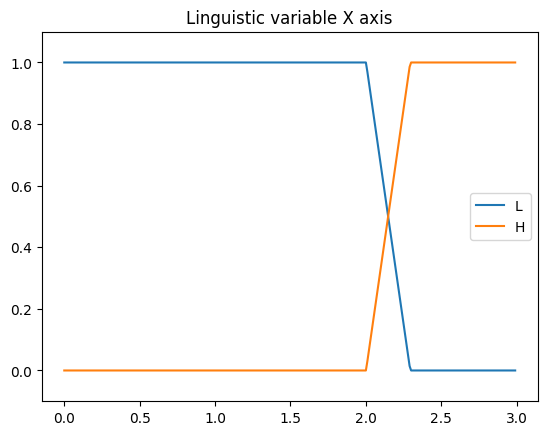

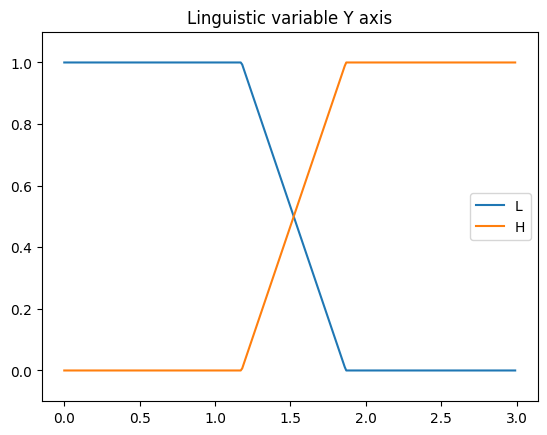

Training data results:


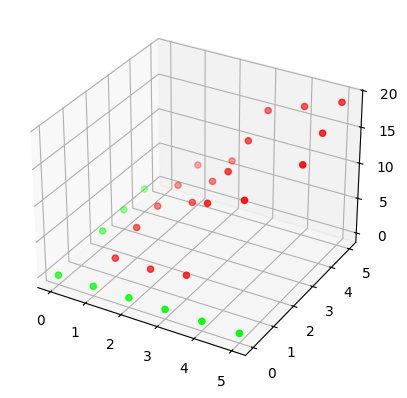

Evaluation data results:


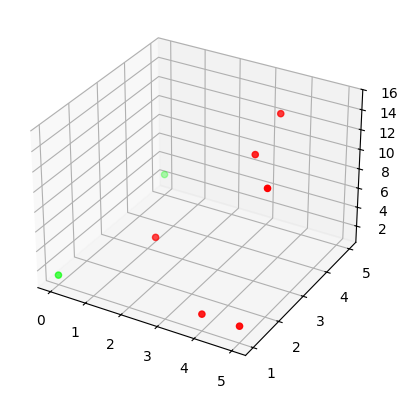

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [3, 15, 1, 2, 13, 13, 5, 2]
[[0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]



Training with operator einsteinS
Initial params for einsteinS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.98829113 0.97179571 0.7898628 ]
 [0.07833664 0.67111678 0.62912158]
 [0.97424712 0.77942682 0.03546324]
 [0.410248   0.74420453 0.60842588]]


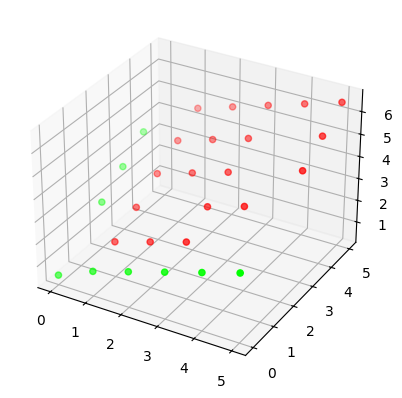

Optymalization finished!
With errors:   57.53439298864057
No ev:  26589
No it:  50
Training results:
Time elapsed: 8.537784099578857
Membership functions after learning:


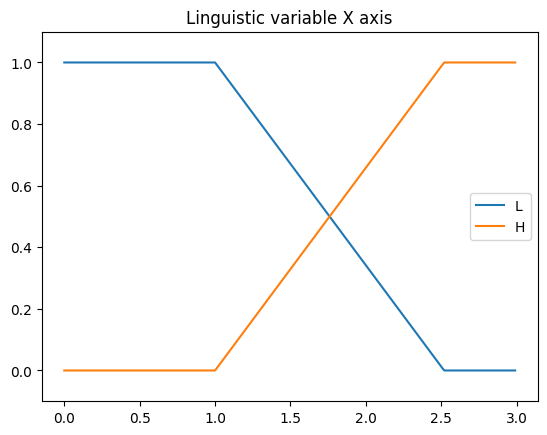

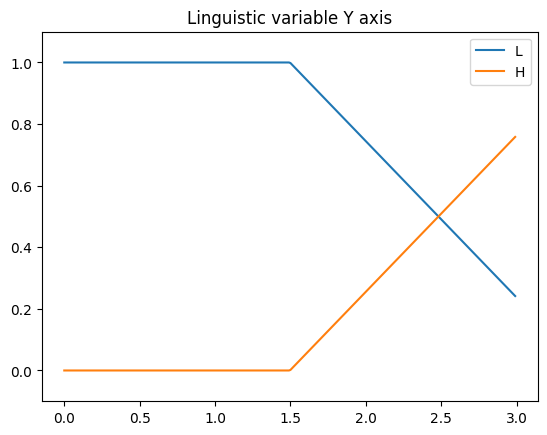

Training data results:


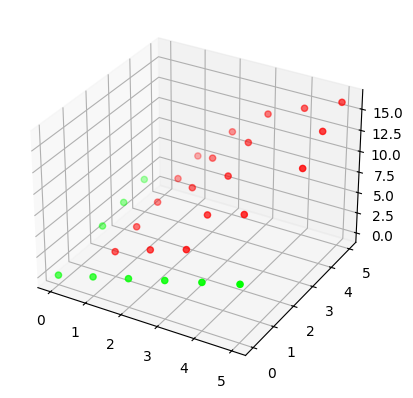

Evaluation data results:


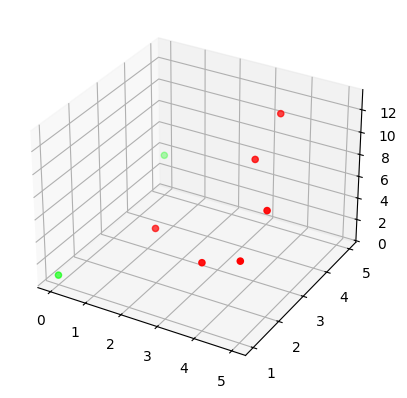

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [4, 13, 1, 6, 9, 11, 5, 7]
[[0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator fodorT
Initial params for fodorT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.03825868 0.33326568 0.76526846]
 [0.61160518 0.40178104 0.68869132]
 [0.59625507 0.39661584 0.3418815 ]
 [0.26545776 0.85702846 0.92270887]]


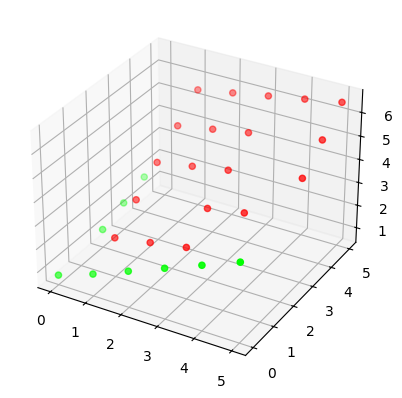

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   14.867697809368742
No ev:  35342
No it:  50
Training results:
Time elapsed: 11.462441444396973
Membership functions after learning:


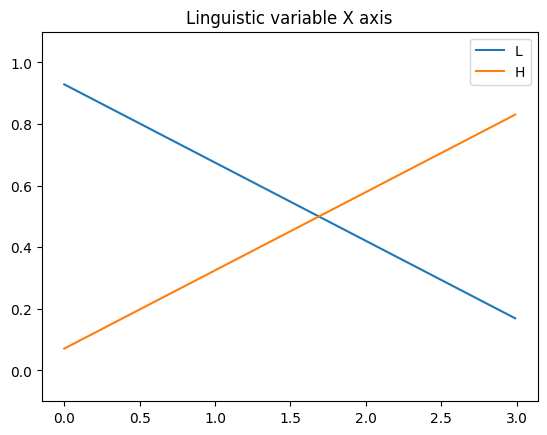

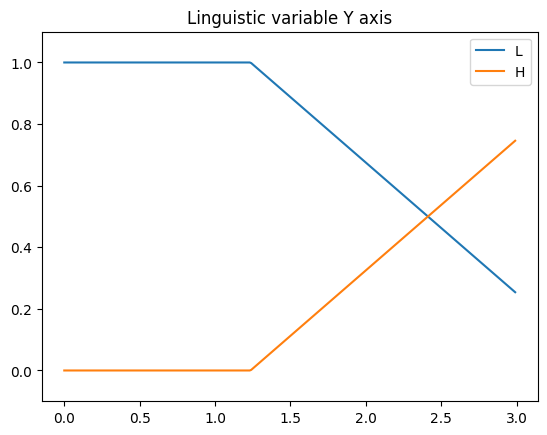

Training data results:


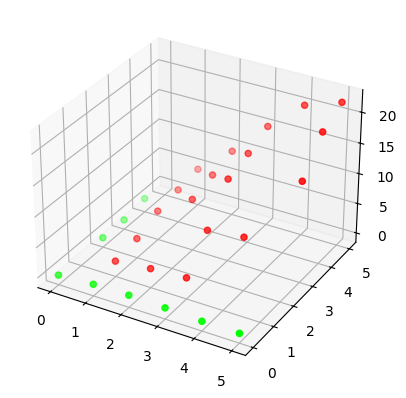

Evaluation data results:


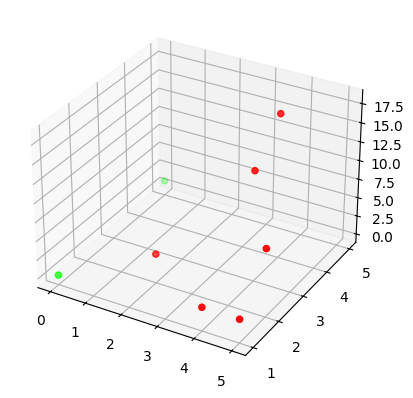

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [1, 18, 0, 2, 8, 14, 3, 2]
[[1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]]



Training with operator fodorS
Initial params for fodorS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.00426002 0.30317361 0.09092499]
 [0.6561004  0.50034606 0.15478097]
 [0.4638139  0.41949696 0.13790354]
 [0.99626028 0.12067559 0.42169867]]


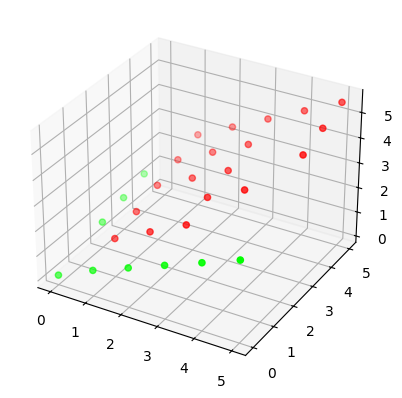

Optymalization finished!
With errors:   57.55666680864344
No ev:  23915
No it:  50
Training results:
Time elapsed: 7.734245300292969
Membership functions after learning:


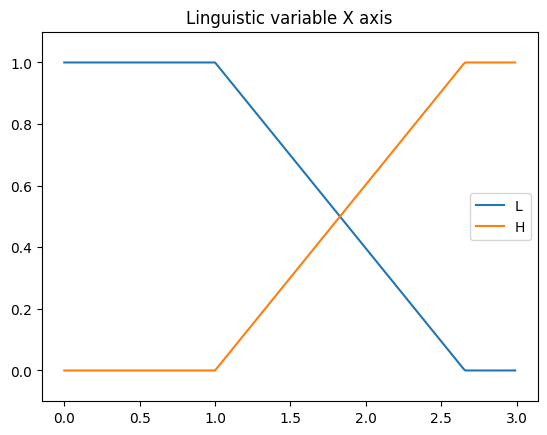

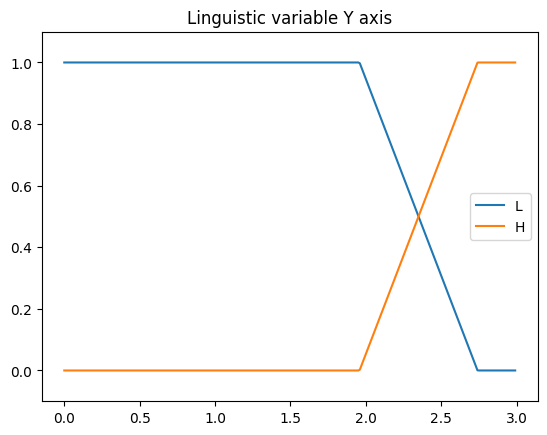

Training data results:


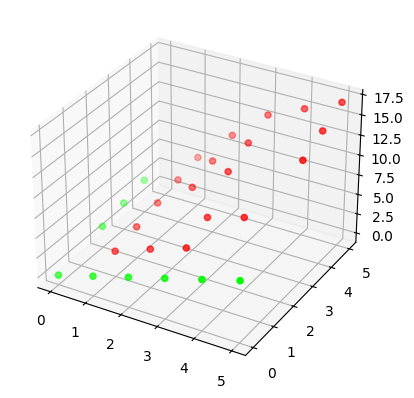

Evaluation data results:


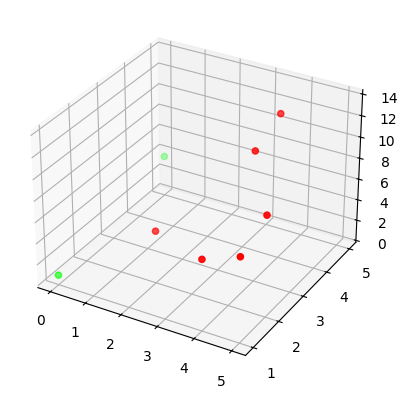

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [4, 13, 1, 7, 9, 12, 5, 8]
[[0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]



Training with operator drasticT
Initial params for drasticT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.03145655 0.25167487 0.48447791]
 [0.96886771 0.4134336  0.7318301 ]
 [0.22277187 0.65554771 0.02124343]
 [0.78292523 0.70176945 0.76157268]]


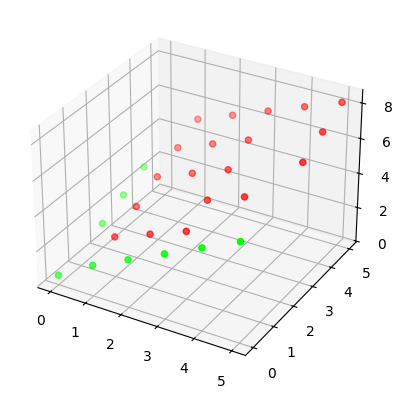

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   23.00934053029877
No ev:  32769
No it:  50
Training results:
Time elapsed: 11.166184186935425
Membership functions after learning:


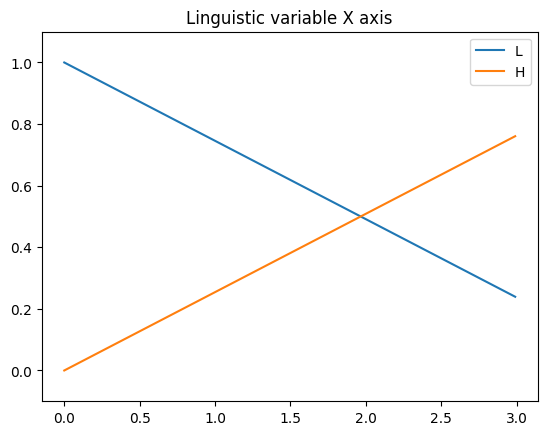

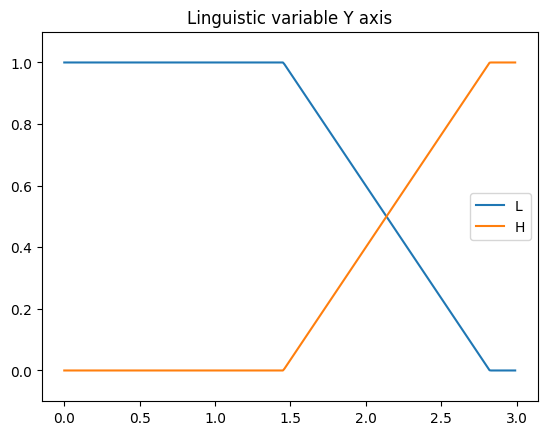

Training data results:


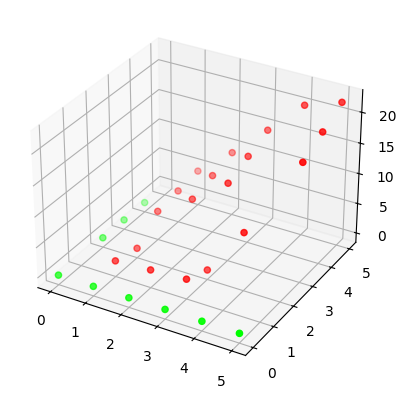

Evaluation data results:


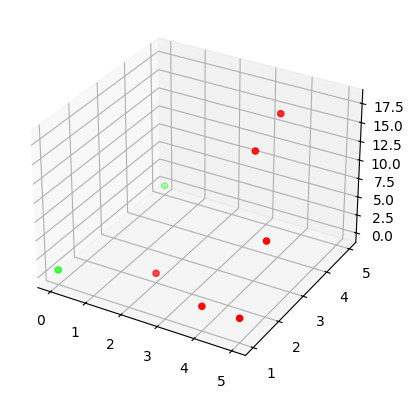

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [0, 18, 1, 2, 9, 16, 0, 2]
[[1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]]



Training with operator drasticS
Initial params for drasticS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.05539748 0.3448066  0.01550257]
 [0.37195057 0.78533455 0.26538286]
 [0.90723889 0.75508473 0.40607946]
 [0.50572929 0.13220541 0.29110974]]


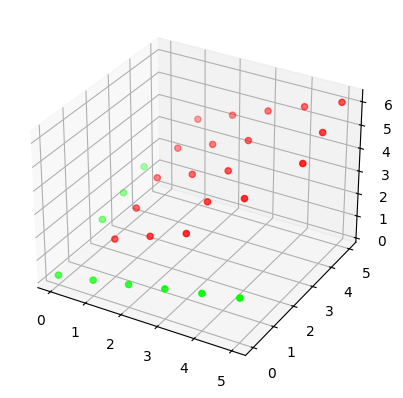

Optymalization finished!
With errors:   56.784829657011976
No ev:  24804
No it:  50
Training results:
Time elapsed: 8.68014645576477
Membership functions after learning:


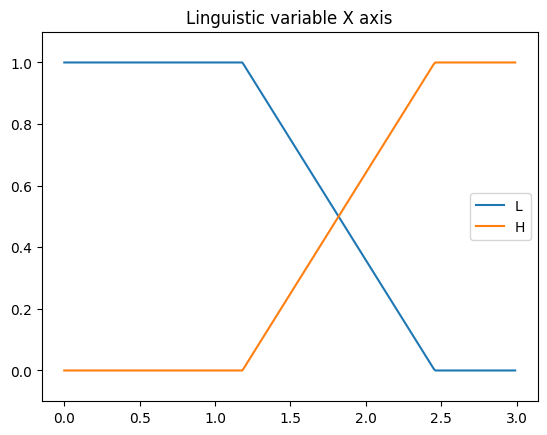

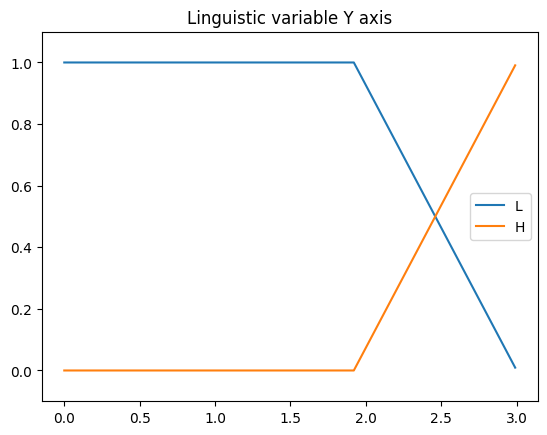

Training data results:


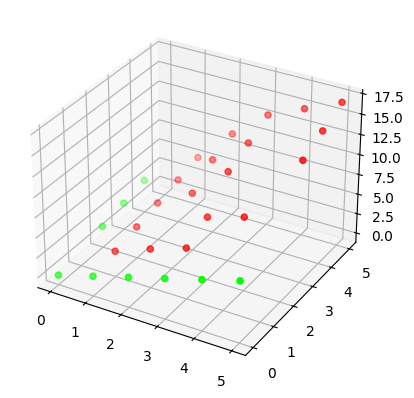

Evaluation data results:


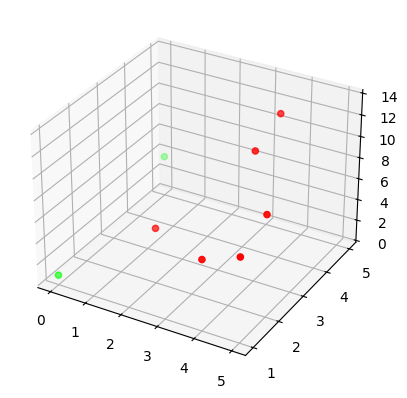

y_test:
 [ 0 16  0  4 10 12  4  5]
y_pred:
 [4, 13, 1, 6, 9, 12, 5, 8]
[[0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]



Training with operator zadehT
Initial params for zadehT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.8562311  0.9147447  0.44342935]
 [0.22786179 0.07224838 0.46147572]
 [0.92413944 0.36471157 0.41461001]
 [0.54375779 0.07743636 0.69689677]]


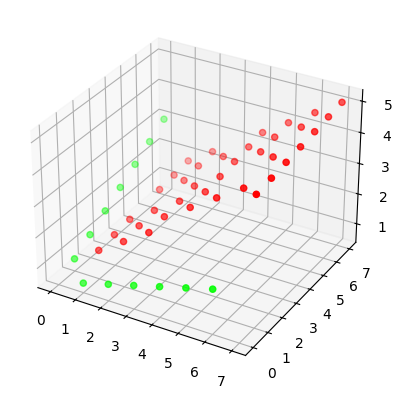

Optymalization finished!
With errors:   116.00232781087682
No ev:  33576
No it:  50
Training results:
Time elapsed: 9.941717147827148
Membership functions after learning:


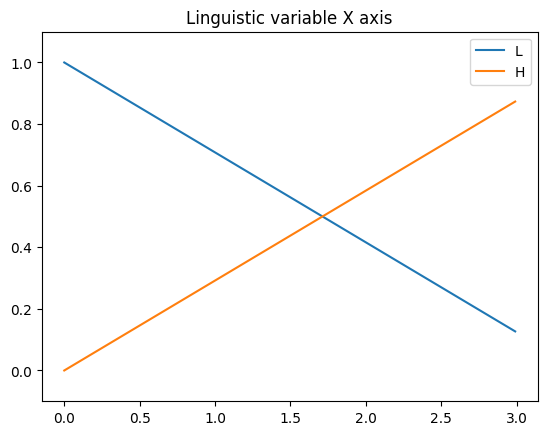

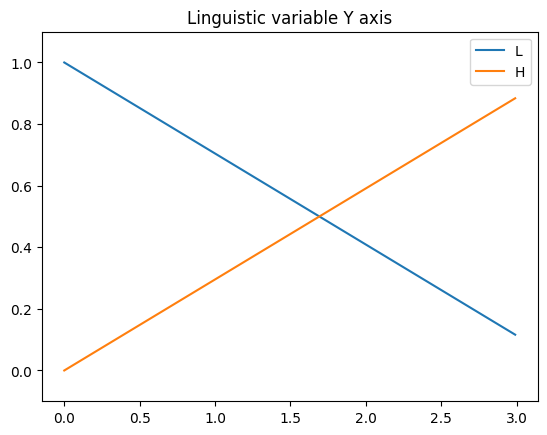

Training data results:


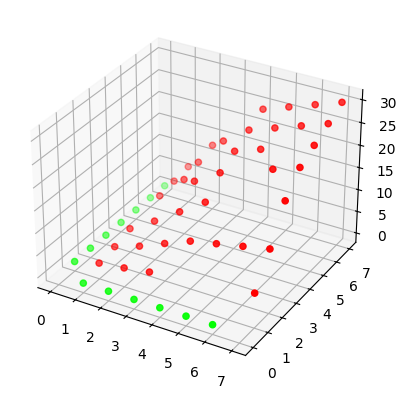

Evaluation data results:


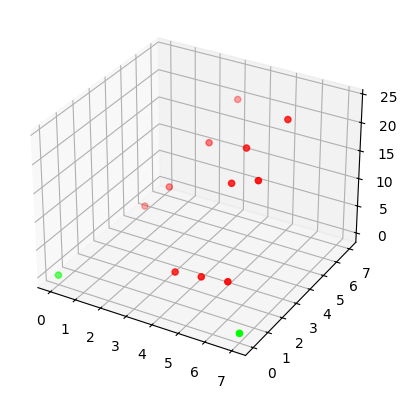

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [16, 0, 4, 0, 24, 20, 5, 20, 4, 9, 16, 18, 4]
[[2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator zadehS
Initial params for zadehS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.18338617 0.02214406 0.98881913]
 [0.83817764 0.31424793 0.60542086]
 [0.88585807 0.81222911 0.18530211]
 [0.31497095 0.73196318 0.76629074]]


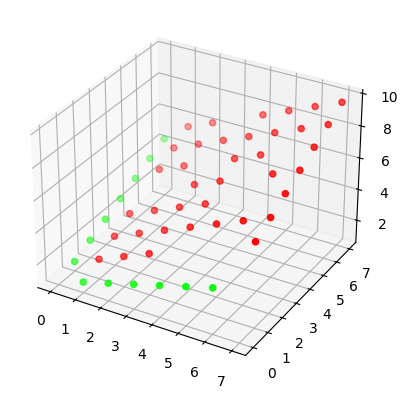

Optymalization finished!
With errors:   225.00629336919366
No ev:  26338
No it:  50
Training results:
Time elapsed: 7.68425178527832
Membership functions after learning:


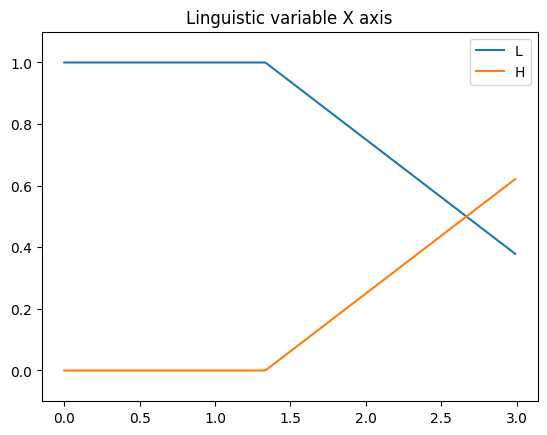

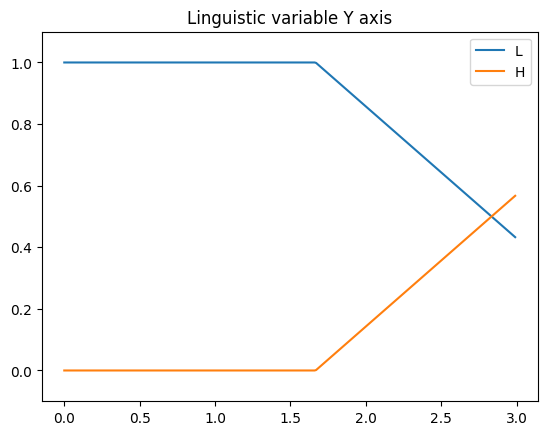

Training data results:


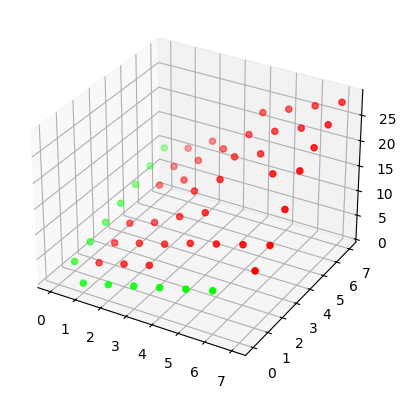

Evaluation data results:


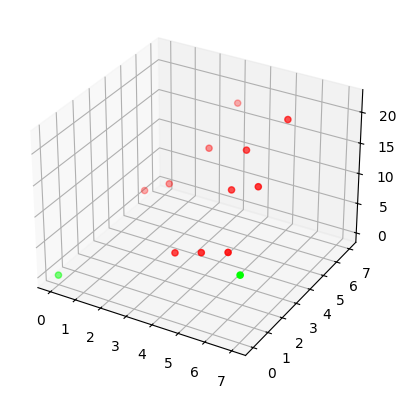

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [14, 0, 8, 9, 22, 18, 9, 18, 7, 9, 14, 15, 7]
[[1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator algebraicT
Initial params for algebraicT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.13423353 0.06502274 0.12549926]
 [0.58357024 0.04514529 0.35026915]
 [0.2885875  0.8646531  0.89458261]
 [0.11135199 0.24715235 0.16054329]]


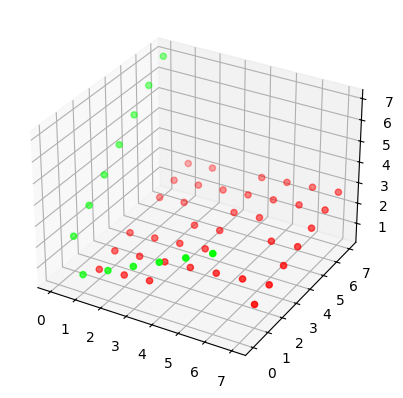

Optymalization finished!
With errors:   117.93761438526649
No ev:  30937
No it:  50
Training results:
Time elapsed: 8.999818563461304
Membership functions after learning:


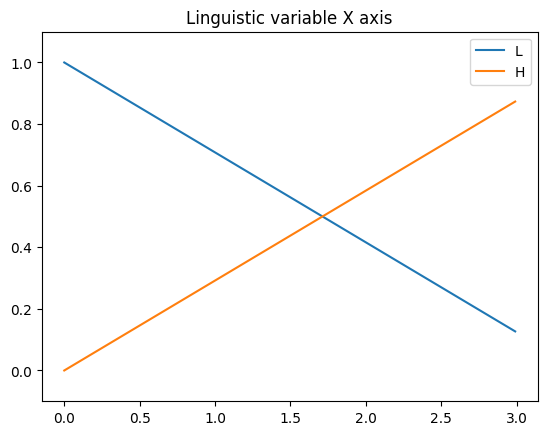

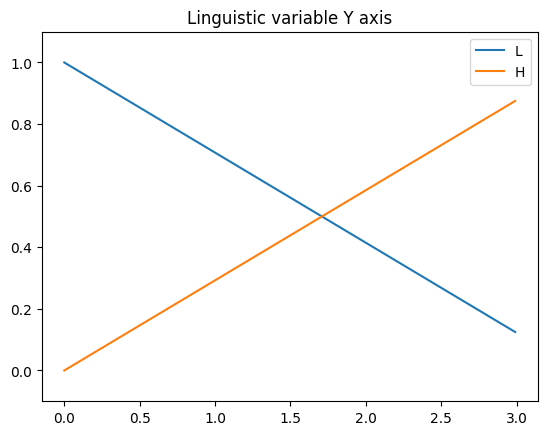

Training data results:


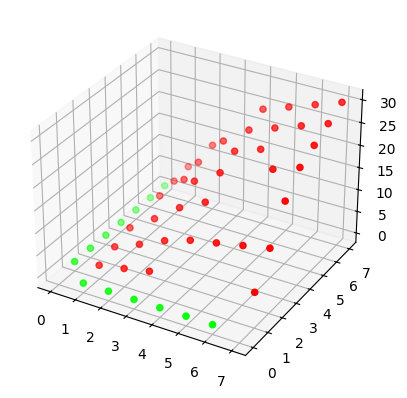

Evaluation data results:


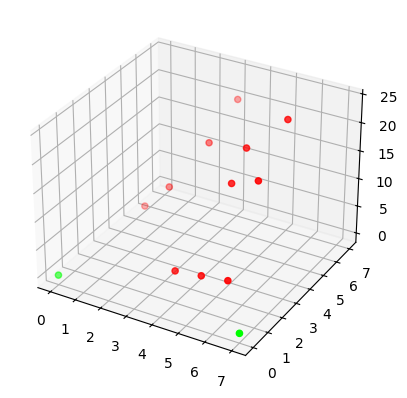

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [16, 0, 5, 0, 24, 20, 5, 20, 4, 9, 16, 18, 4]
[[2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator probabilisticS
Initial params for probabilisticS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.63752074 0.45305157 0.09135574]
 [0.24531067 0.79503123 0.95146917]
 [0.91789381 0.17290406 0.93296122]
 [0.98407291 0.73272055 0.35681096]]


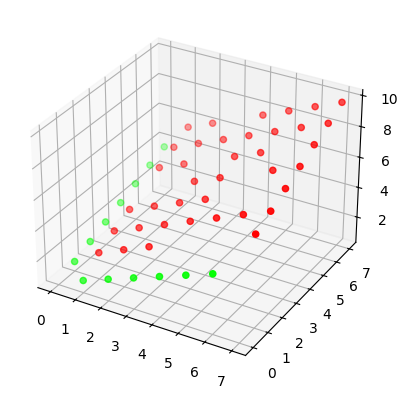

Optymalization finished!
With errors:   224.94065032372828
No ev:  25273
No it:  50
Training results:
Time elapsed: 7.7414844036102295
Membership functions after learning:


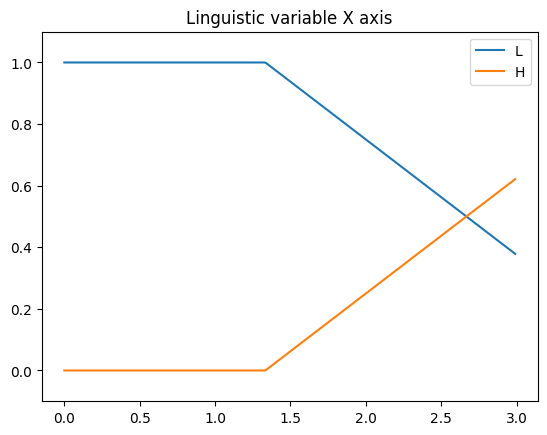

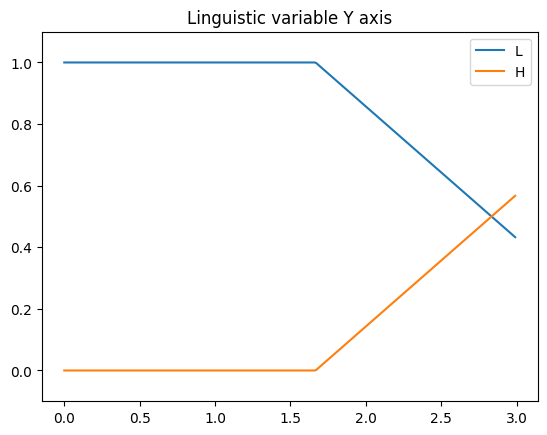

Training data results:


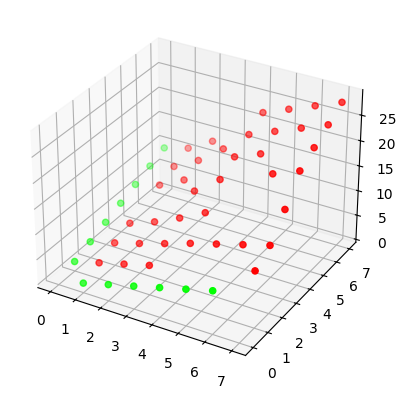

Evaluation data results:


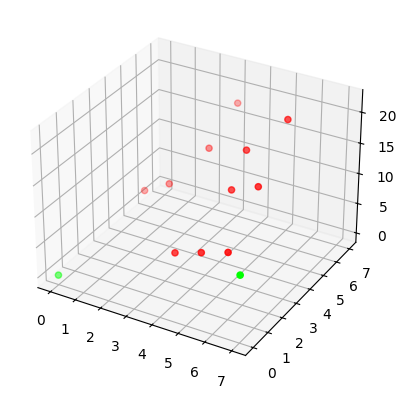

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [14, 0, 8, 9, 22, 18, 9, 18, 7, 9, 14, 15, 7]
[[1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator lukasiewiczT
Initial params for lukasiewiczT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.07700121 0.17235563 0.24441824]
 [0.56560725 0.88935799 0.5384966 ]
 [0.4950736  0.11030949 0.07750887]
 [0.09148332 0.14948329 0.40709411]]


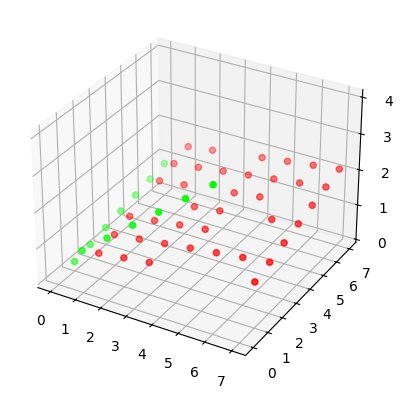

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   127.50292376153115
No ev:  38830
No it:  50
Training results:
Time elapsed: 13.303329706192017
Membership functions after learning:


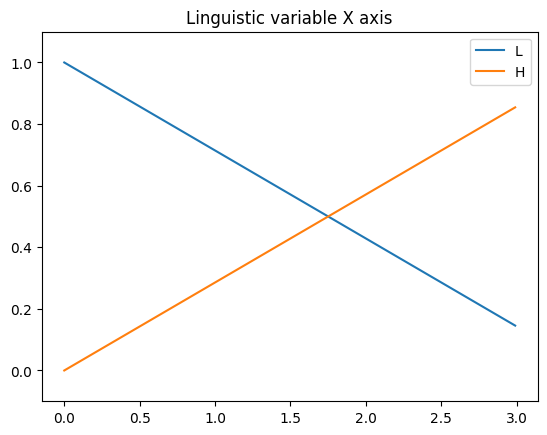

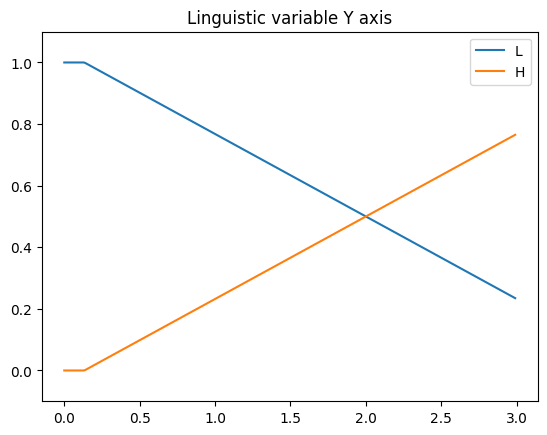

Training data results:


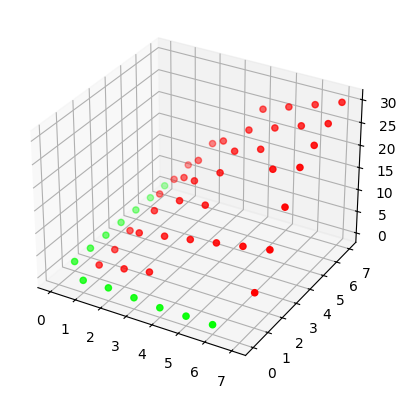

Evaluation data results:


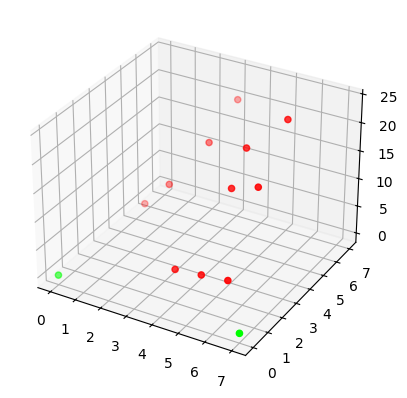

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [15, 0, 5, 0, 24, 20, 5, 20, 4, 10, 16, 17, 5]
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator lukasiewiczS
Initial params for lukasiewiczS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.22877622 0.46299436 0.89356159]
 [0.61546087 0.07838143 0.54394295]
 [0.54798458 0.48489193 0.6280859 ]
 [0.45280543 0.49998705 0.88616684]]


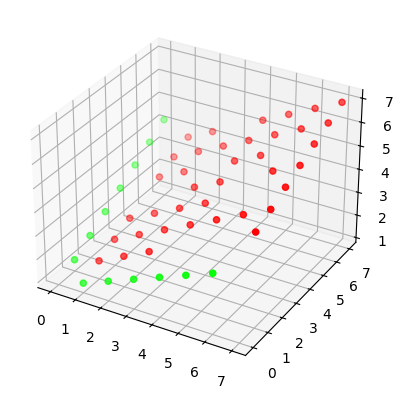

Optymalization finished!
With errors:   225.06975112033496
No ev:  25434
No it:  50
Training results:
Time elapsed: 8.38323187828064
Membership functions after learning:


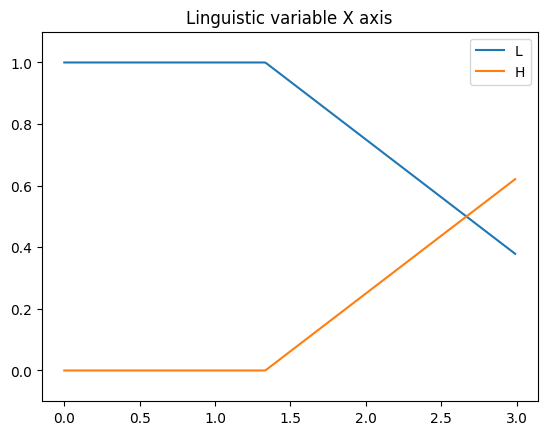

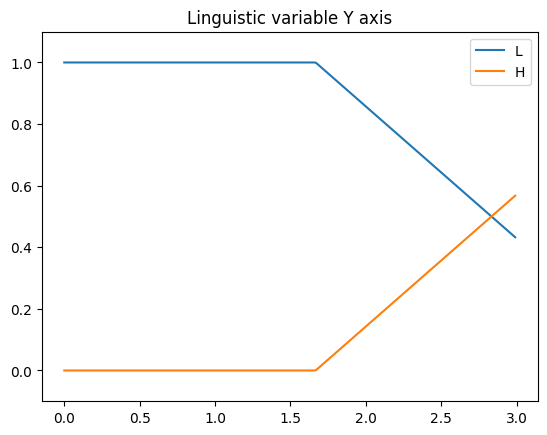

Training data results:


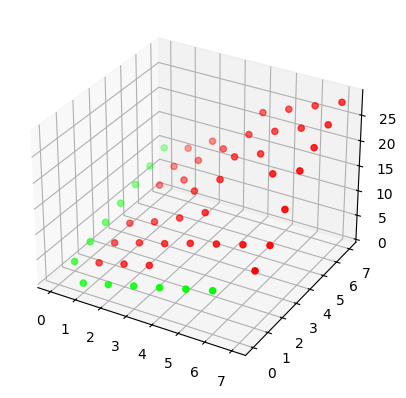

Evaluation data results:


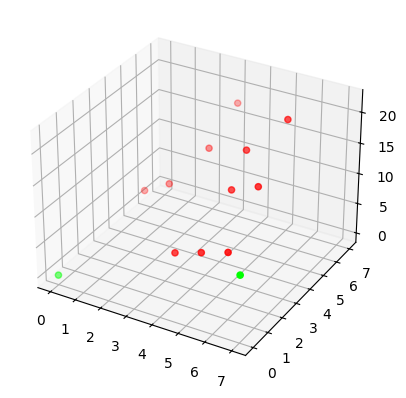

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [14, 0, 8, 9, 22, 18, 9, 17, 7, 9, 14, 15, 7]
[[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator einsteinT
Initial params for einsteinT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.86667683 0.28245115 0.27299389]
 [0.6866764  0.33820702 0.80057351]
 [0.48497381 0.59584016 0.96161141]
 [0.95744312 0.18544597 0.20364785]]


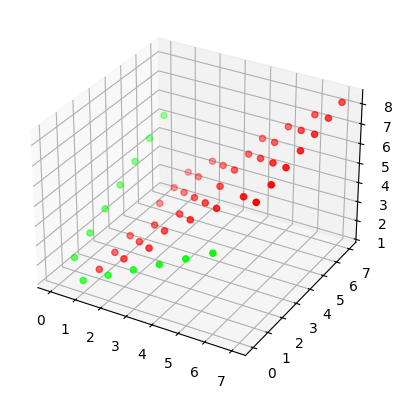

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   190.0
No ev:  3374
No it:  50
Training results:
Time elapsed: 1.1750271320343018
Membership functions after learning:


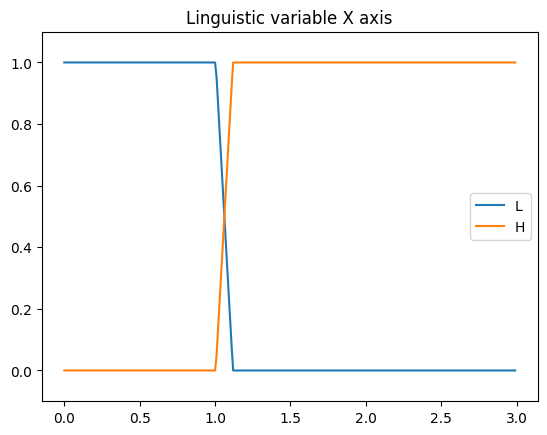

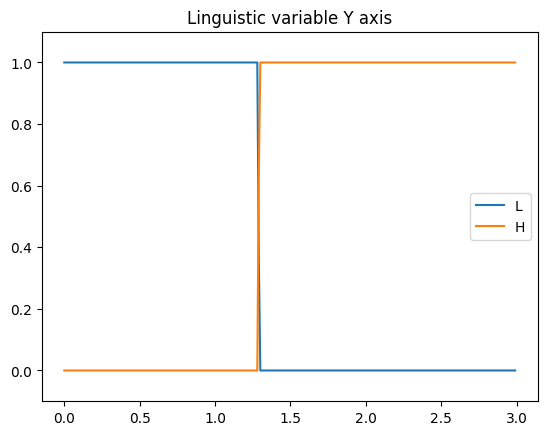

Training data results:


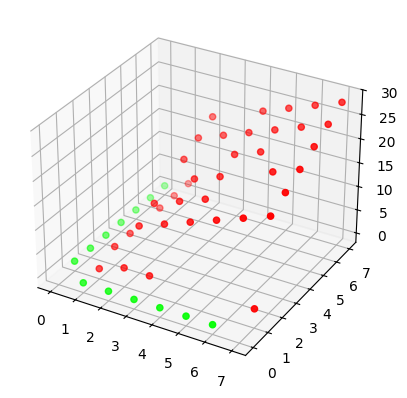

Evaluation data results:


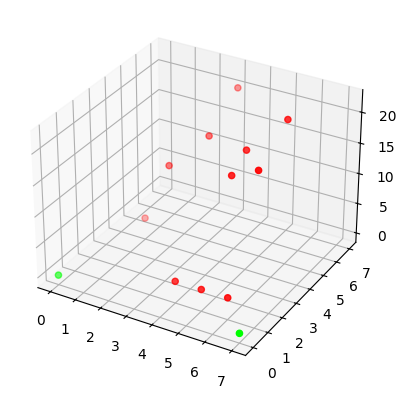

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [16, 0, 2, 0, 22, 18, 2, 20, 2, 12, 16, 18, 2]
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator einsteinS
Initial params for einsteinS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.90808681 0.87839351 0.72361076]
 [0.14342591 0.79737288 0.38446939]
 [0.01771748 0.64571138 0.72668025]
 [0.00630512 0.23371833 0.22848887]]


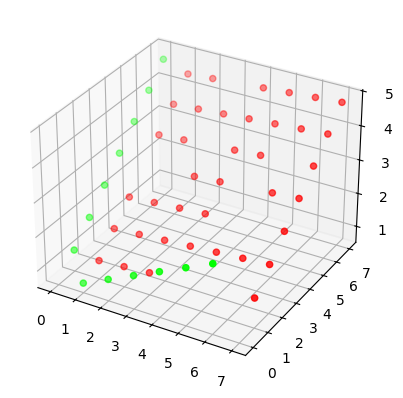

Optymalization finished!
With errors:   224.9795230500698
No ev:  21645
No it:  50
Training results:
Time elapsed: 7.12036395072937
Membership functions after learning:


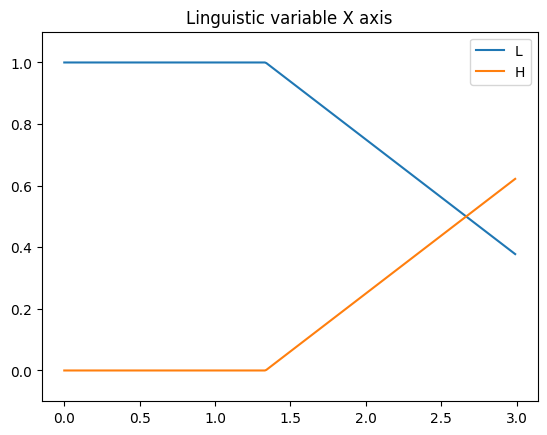

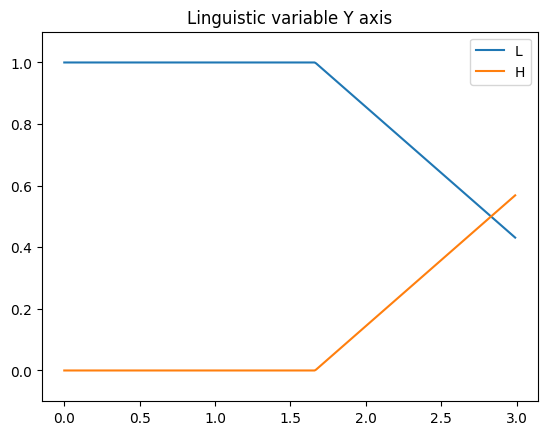

Training data results:


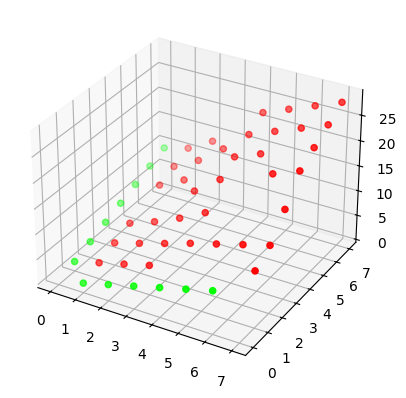

Evaluation data results:


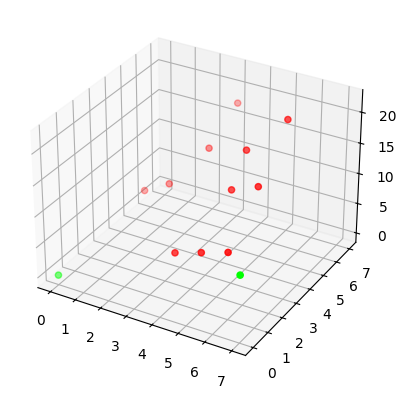

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [14, 0, 8, 9, 22, 18, 9, 18, 7, 9, 14, 15, 7]
[[1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator fodorT
Initial params for fodorT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.58318966 0.54533882 0.33005828]
 [0.18661442 0.9489518  0.73162951]
 [0.53379658 0.11728753 0.36915819]
 [0.43671767 0.9847631  0.12596911]]


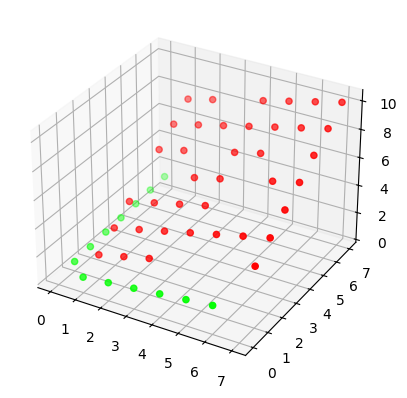

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   126.19200628579185
No ev:  37352
No it:  50
Training results:
Time elapsed: 12.64468765258789
Membership functions after learning:


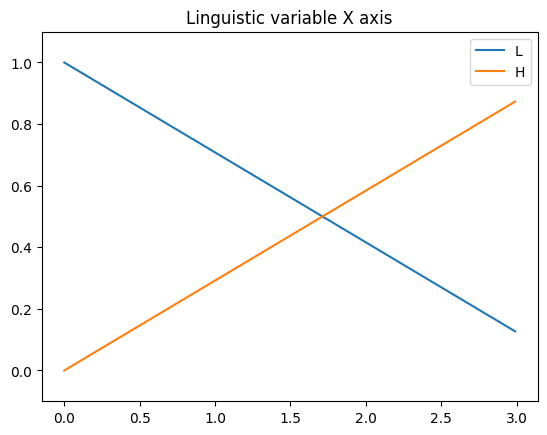

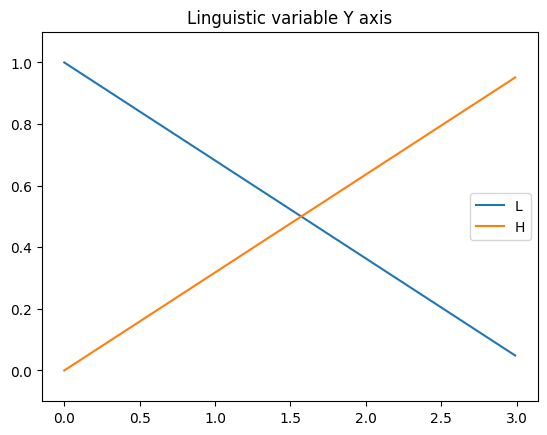

Training data results:


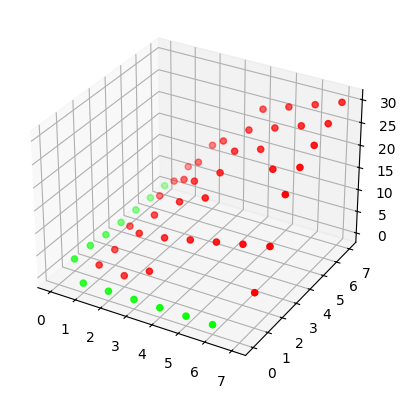

Evaluation data results:


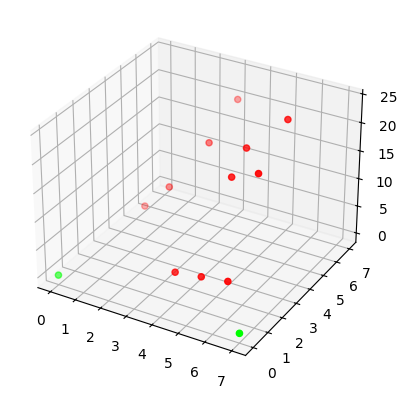

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [17, 0, 4, 0, 24, 20, 5, 20, 4, 9, 16, 19, 4]
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator fodorS
Initial params for fodorS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.47169174 0.38362091 0.12796188]
 [0.40573689 0.60934148 0.34758091]
 [0.17049282 0.12129605 0.60370113]
 [0.38894928 0.68257837 0.80375396]]


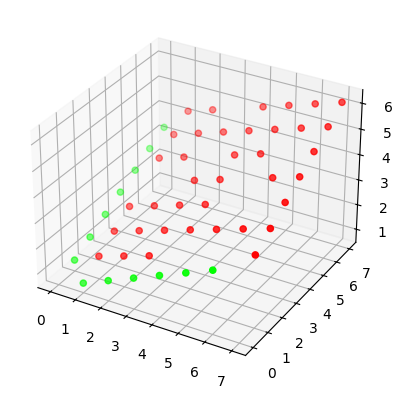

Optymalization finished!
With errors:   224.5253504823912
No ev:  24699
No it:  50
Training results:
Time elapsed: 8.00145697593689
Membership functions after learning:


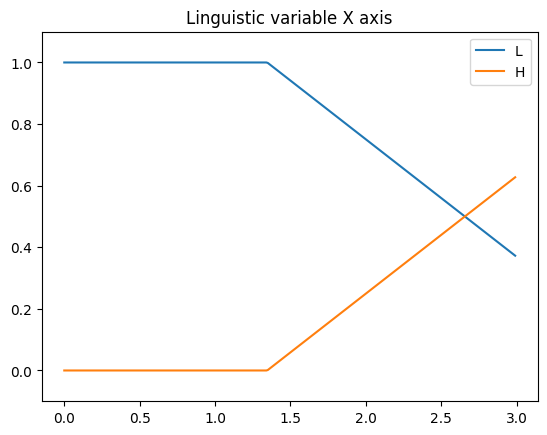

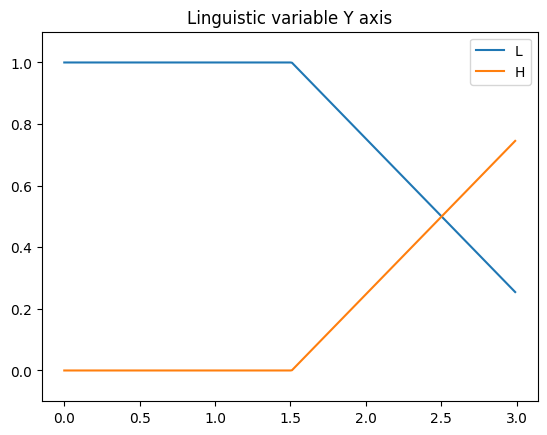

Training data results:


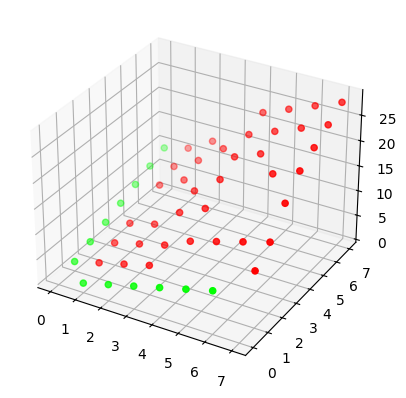

Evaluation data results:


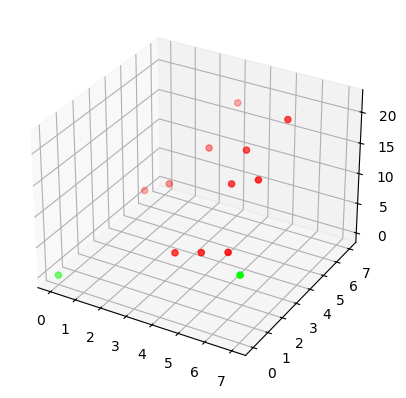

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [15, 0, 8, 9, 22, 18, 9, 18, 7, 9, 14, 17, 7]
[[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator drasticT
Initial params for drasticT operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.05427828 0.89806748 0.11326614]
 [0.40234091 0.82089732 0.51743342]
 [0.40896822 0.39411618 0.15561881]
 [0.69620762 0.4802888  0.94874535]]


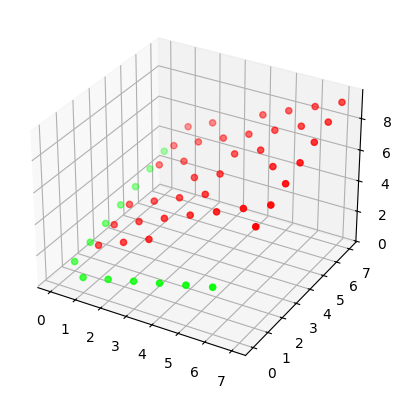

/home/skuban/Studies/2sem/is/IntelligentSystems/ANFIS/ANFIS.py:126: RuntimeWarning: invalid value encountered in divide
  


Optymalization finished!
With errors:   134.85292514075715
No ev:  31657
No it:  50
Training results:
Time elapsed: 11.036705493927002
Membership functions after learning:


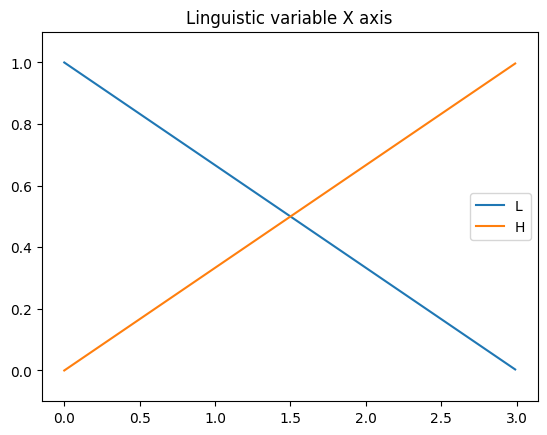

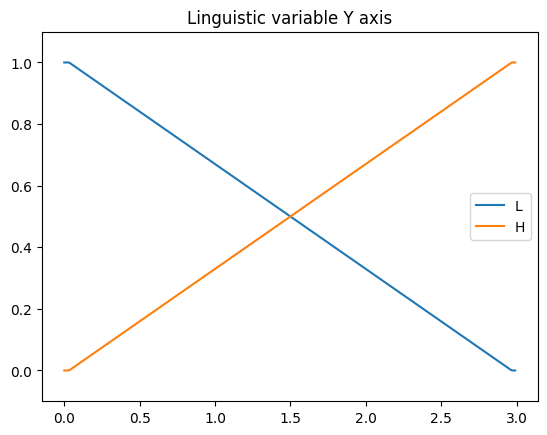

Training data results:


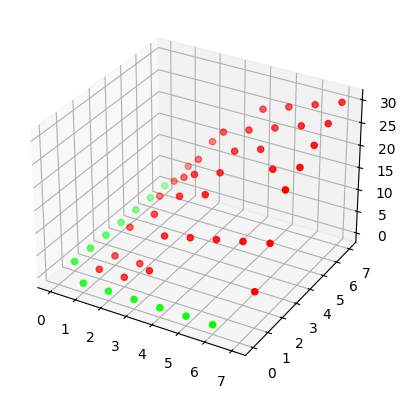

Evaluation data results:


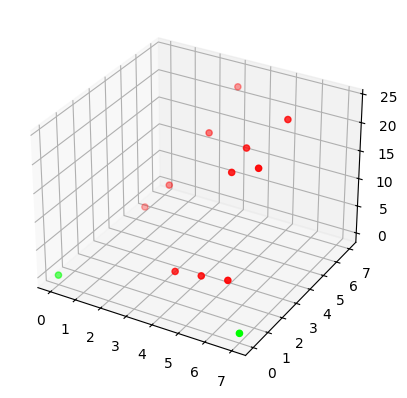

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [18, 0, 5, 0, 24, 20, 5, 22, 4, 10, 18, 20, 4]
[[2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]]



Training with operator drasticS
Initial params for drasticS operator:
Premises:  [[0.5, 0.5], [0.5, 0.5]] 
Conclusions:  [[0.9799026  0.82806221 0.8793531 ]
 [0.3214587  0.02585735 0.3620811 ]
 [0.8421101  0.77787932 0.96621732]
 [0.34287716 0.15151511 0.96525093]]


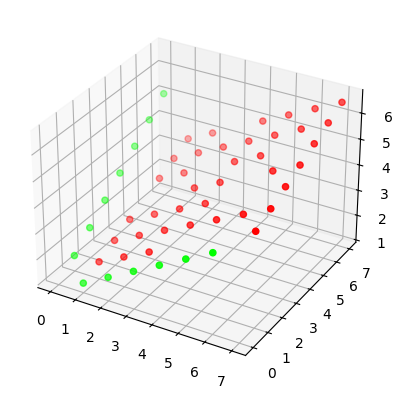

Optymalization finished!
With errors:   224.35491114842623
No ev:  24796
No it:  50
Training results:
Time elapsed: 8.360739946365356
Membership functions after learning:


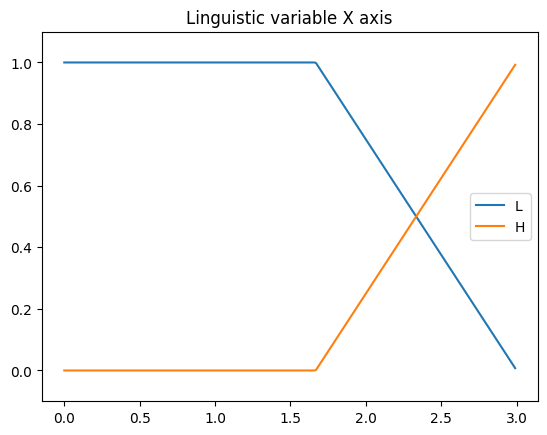

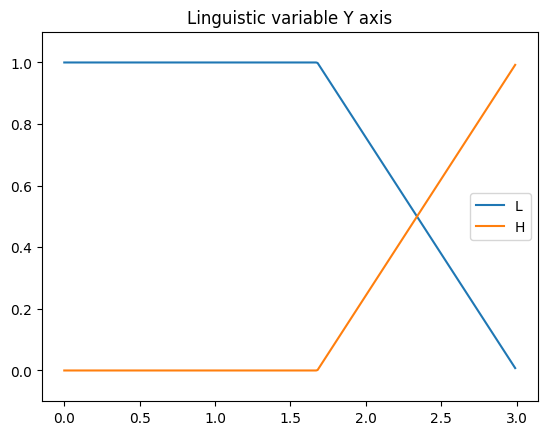

Training data results:


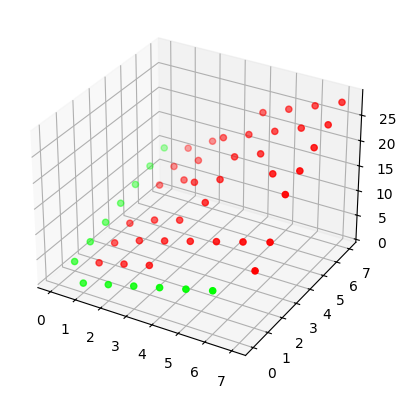

Evaluation data results:


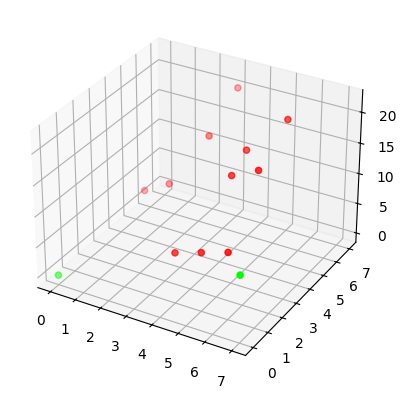

y_test:
 [15  0  5  0 30 20  6 21  4  8 15 18  4]
y_pred:
 [16, 0, 8, 9, 22, 18, 9, 20, 7, 9, 16, 18, 7]
[[1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]




In [101]:
operators = [
    op.zadehT,
    op.zadehS,
    op.algebraicT,
    op.probabilisticS,
    op.lukasiewiczT,
    op.lukasiewiczS,
    op.einsteinT,
    op.einsteinS,
    op.fodorT,
    op.fodorS,
    op.drasticT,
    op.drasticS
]
results = []
results2 = []

X_test, y_test, X_train, y_train = prepare_data(6)

for operator in operators:
    training_method(X_test, y_test, X_train, y_train, operator, results)

X_test, y_test, X_train, y_train = prepare_data(8)
for operator in operators:
    training_method(X_test, y_test, X_train, y_train, operator, results2)

In [102]:
results.sort(key=lambda x:x['test_accuracy'], reverse=True)
results2.sort(key=lambda x:x['test_accuracy'], reverse=True)
for r in results:
    print("=========================")
    for k, v in r.items():
        print(k, v)

for r in results2:
    print("=========================")
    for k, v in r.items():
        print(k, v)


operator algebraicT
time_elapsed 11.665167093276978
test_accuracy 0.5
confusion_matrix [[2 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]]
operator zadehT
time_elapsed 12.018983602523804
test_accuracy 0.375
confusion_matrix [[2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]]
operator zadehS
time_elapsed 11.235738039016724
test_accuracy 0.125
confusion_matrix [[0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]
operator probabilisticS
time_elapsed 12.232364